# 0_read_data

In [92]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 35) ## 생략 없이 한 번에 띄울 피쳐수 = 35
import warnings
warnings.filterwarnings('ignore')
from my_func import *

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc("font",family="Malgun Gothic") ## 폰트       한글 깨짐
plt.rc("axes",unicode_minus=False)    ## 폰트 minus 부호 깨짐
plt.style.use("ggplot")

df1 = pd.read_parquet( "data\df1.parquet" )
df3 = pd.read_parquet( "data\df3.parquet" )

def sp():
    print(f"     {df1.shape[0]:,} x {df1.shape[1]}          {df3.shape[0]:,} x {df3.shape[1]}")
    display(df1.head(1))
    display(df3.head(1))
sp()

     5,623,810 x 23          544,921 x 31


,id,age,man,push,frgn,birth,sign,buy,m_id,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,buy_cut,buy_y,buy_m,buy_d,buy_7,cnt_b
0,357745,58,1,1,0,1963-03-08,2019-08-01 00:35:35.508,2019-08-01 00:32:56.331,9,43000,35000,0,8000,8000,0.0,18.6,18.6,2019-08-01,2019,8,1,3,1


,id,age,man,push,frgn,birth,sign,sign_cut,sign_y,sign_m,sign_d,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,2019,8,25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,0,1,0,0,0,1,0,0,0,0


In [2]:
### df1, df3 시계열 추출 피쳐, 상업코드 피쳐 삭제
df1 = df1[['id', 'age', 'man', 'push', 'frgn', 'birth', 'sign', 'buy', 'buy_cut', 'm_id', 'pre', 'post', 'c_back', 'dscnt', 'total', 'c_back_R', 'dscnt_R', 'total_R', 'cnt_b']]
df3 = df3[['id', 'age', 'man', 'push', 'frgn', 'birth', 'sign', 'sign_cut', 'pre', 'post', 'c_back', 'dscnt', 'total', 'c_back_R', 'dscnt_R', 'total_R', 'cnt_p', 'cnt_b']]
sp()

     5,623,810 x 19          544,921 x 18


,id,age,man,push,frgn,birth,sign,buy,buy_cut,m_id,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_b
0,357745,58,1,1,0,1963-03-08,2019-08-01 00:35:35.508,2019-08-01 00:32:56.331,2019-08-01,9,43000,35000,0,8000,8000,0.0,18.6,18.6,1


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2


# 1_보따리상 정의
- 매출과 관련한 큰 손 유저 중에서
- 명확하게 구분되는 특정한 패턴 존재? ---> 군집 가능 (특성 찾아보자)

### 1_같은날, 동일가격상품을 반복 결제
- 이런 경우가 흔한가?

In [3]:
### 압축(groupby): 동일인물, 동일일자, 동일금액 기준

data = df1[["id","buy_cut","pre","cnt_b"]]
data = data.rename(columns={"cnt_b":"repeat"})
data = data.groupby(["id","buy_cut","pre"]).sum()
data

### 각 유저별 반복구매 범위: 1 <= repeat <= 자신의구매횟수

repeat
id     buy_cut    pre          
1      2019-08-25 10110       1
       2019-08-27 14220       1
2      2019-08-09 13530       1
       2019-10-15 11500       1
3      2019-08-24 18120       1
...                         ...
544921 2019-12-05 12900       1
       2019-12-14 15900       1
       2019-12-28 13900       1
       2020-01-12 11900       1
       2020-03-29 45200       1

[5425334 rows x 1 columns]

In [4]:
infox(data[["repeat"]])
### 전체 평균 반복구매 ---> 1.03 회

◆◆◆ (5425334, 1): Total shape ◆◆◆
---(5425334, 1): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)  dtype  n_uniq  |   Mean     Std  |max-min|  │  min  Q1  median  Q3  max  
 0  repeat     0      0.0  int64      35  |  1.037  0.2574         62  │    1   1       1   1   63  
------------------------------------------------------------------------------ 



In [5]:
### id, repeat 만 남긴다 
temp = data.reset_index().drop(["buy_cut","pre"],axis=1)
display(temp.head(3))

### 전체거래의 3.5% 만 repeat --> 반복구매에 해당된다.
print(round(100 - 100*temp.shape[0]/len(df1),1))

,id,repeat
0,1,1
1,1,1
2,2,1


3.5


In [6]:
temp1 = temp.groupby("id").max().reset_index()  # temp1: 유저별 반복구매 최대 횟수
temp1 = temp1.rename(columns={"repeat":"RP_max"})

temp2 = temp.groupby("id").mean().reset_index() # temp2: 유저별 반복구매 평균 횟수
temp2["repeat"] = round(temp2["repeat"],2)
temp2 = temp2.rename(columns={"repeat":"RP_mean"})

df3 = pd.merge( df3, temp1, how="left", on="id" )
df3 = pd.merge( df3, temp2, how="left", on="id" )
display(df3.head(3))

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.0
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,2019-08-24,18120,13440,0,4680,4680,0.0,25.8,25.8,1,1,1,1.0


In [7]:
### max=63 / mean=14
infox(df3[["RP_max","RP_mean"]])

◆◆◆ (544921, 2): Total shape ◆◆◆
---(544921, 2): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |   Mean     Std  |max-min|  │  min  Q1  median  Q3  max  
 0   RP_max     0      0.0    int64      34  |  1.172  0.5701         62  │    1   1       1   1   63  
 1  RP_mean     0      0.0  float64     238  |  1.032  0.1634         13  │    1   1       1   1   14  
------------------------------------------------------------------------------ 



In [8]:
### 하루에 63번 반복구매한 유저
display(df3.loc[df3.RP_max==63])

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
226413,226414,43,1,0,0,1978-05-20,2019-07-26 11:09:35.093,2019-07-26,8573050,8214550,0,358500,358500,0.0,4.2,4.2,1,144,63,4.24


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
226413,226414,43,1,0,0,1978-05-20,2019-07-26 11:09:35.093,2019-07-26,8573050,8214550,0,358500,358500,0.0,4.2,4.2,1,144,63,4.24


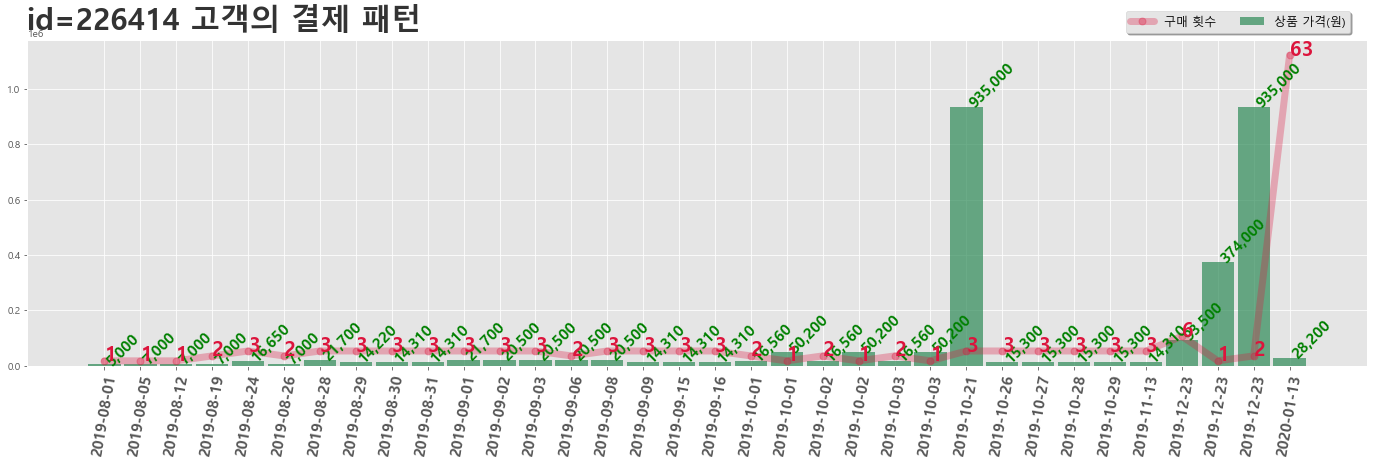

In [9]:
### 유저 반복결제 pattern 파악하는 함수
def patt(id):
    display(df3.loc[df3.id==id])
    df = df1.set_index("id")
    df = df.loc[id,["buy_cut","pre"]]
    df["repeat"] = 1
    df = df.groupby(["buy_cut","pre"]).sum().reset_index()
    
    N, max_pre, max_RP = len(df), np.max(df.pre), np.max(df.repeat)
    x,y1,y2 = range(N), df.pre, df.repeat.apply(lambda x:x*(1.2*max_pre//max_RP)) #---- 2개 그래프 한 판에 겹치려고..
    x_name = df.buy_cut.astype(str) #-------------------------------------------------- x축 눈금 값
    y1_value = df.pre.apply(lambda x:f"{x:,}") #--------------------------------------- 결제금액 콤마 처리

    plt.figure(figsize=((24,6)))
    plt.bar(x, y1, color="SeaGreen", alpha=0.7, width=0.9, label="상품 가격(원)", )
    plt.plot(x, y2, color="Crimson", label="구매 횟수", alpha=0.3, ls="-", linewidth=7, marker='o', ms=7, mfc="Crimson", solid_capstyle='round', )

    for i in range(N):
        plt.text(x[i],y1[i],y1_value[i], size=15, color="Green", weight=1000, rotation=45)
        plt.text(x[i],y2[i],df.repeat[i], size=20, color="Crimson", weight=1000,  )
        
    plt.title(f"id={id} 고객의 결제 패턴", weight=1000, color="k", size=30, alpha=0.8, pad=10, loc="left", )
    plt.xticks(x, x_name, fontsize=15, rotation=80, weight=1000, )
    plt.legend(loc=(0.82,1.02), fontsize=12, ncol=2, frameon=True, shadow=True, )
    plt.show()
    
patt(226414)

In [10]:
### 반복결제 평균이 14인 유저
display(df3.loc[df3.RP_mean==14])

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
460469,460470,38,1,0,0,1983-03-02,2019-12-23 00:38:57.703,2019-12-23,13090000,12810000,0,280000,280000,0.0,2.1,2.1,1,14,14,14.0


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
460469,460470,38,1,0,0,1983-03-02,2019-12-23 00:38:57.703,2019-12-23,13090000,12810000,0,280000,280000,0.0,2.1,2.1,1,14,14,14.0


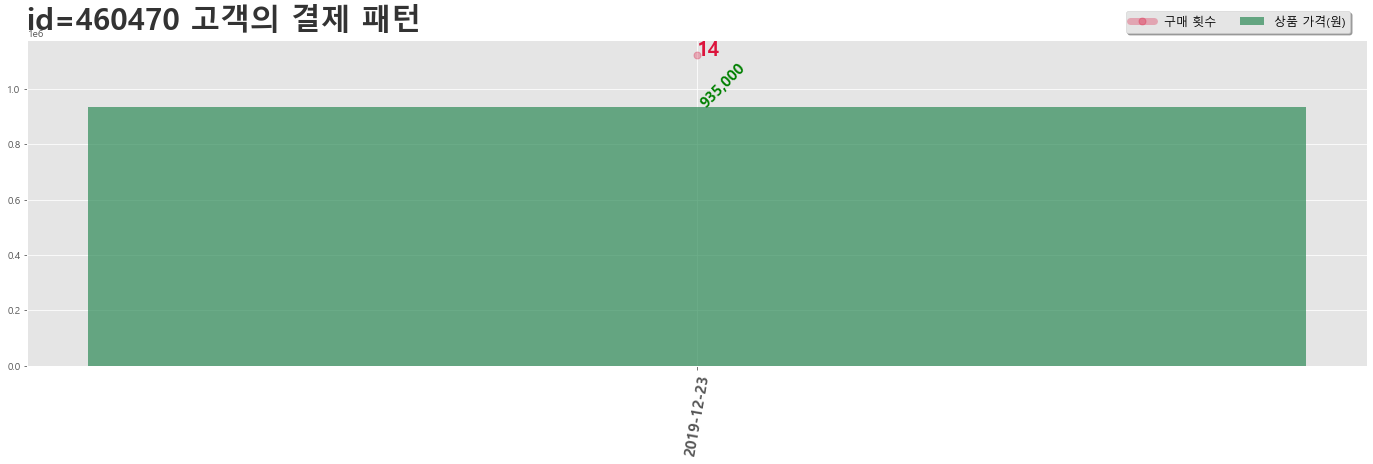

In [11]:
patt(460470)

In [12]:
### 반복결제 최댓값 상위 20명과,
### 반복결제 평균   상위 20명의 패턴 파악 해보자.
case1 = list(df3.sort_values(by="RP_max",ascending=False).head(5).id)
case2 = list(df3.sort_values(by="RP_mean",ascending=False).head(5).id)
case = case1 + case2
print(len(case)) #--------- (심지어 한 명은 겹친다..)

10


,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
226413,226414,43,1,0,0,1978-05-20,2019-07-26 11:09:35.093,2019-07-26,8573050,8214550,0,358500,358500,0.0,4.2,4.2,1,144,63,4.24


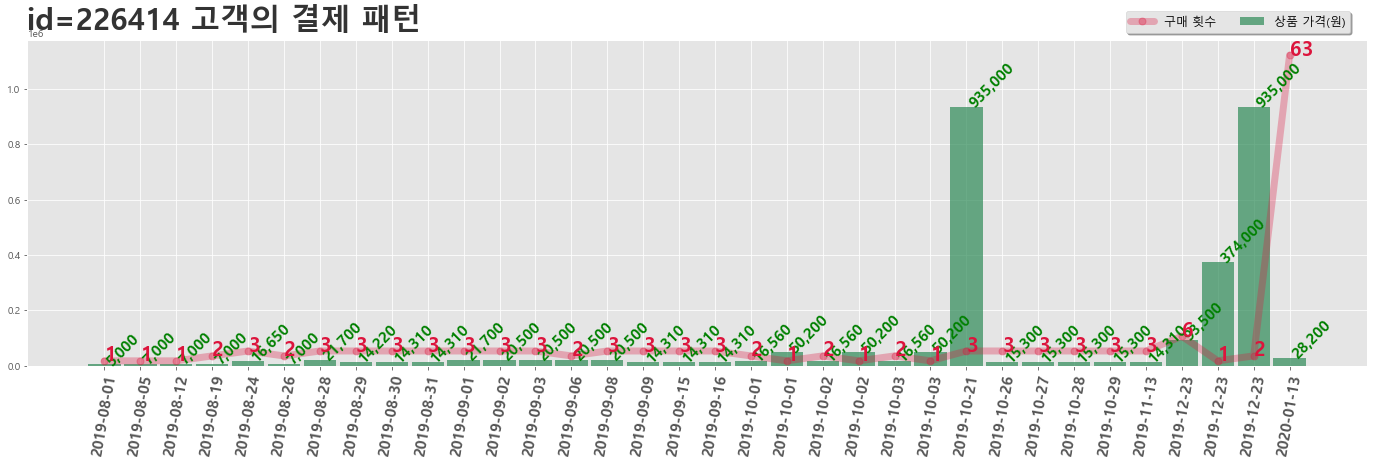

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
96993,96994,40,1,1,0,1981-02-19,2019-10-31 11:01:09.327,2019-10-31,2784113,2738095,80659,46018,126677,2.9,1.7,4.5,1,160,59,2.32


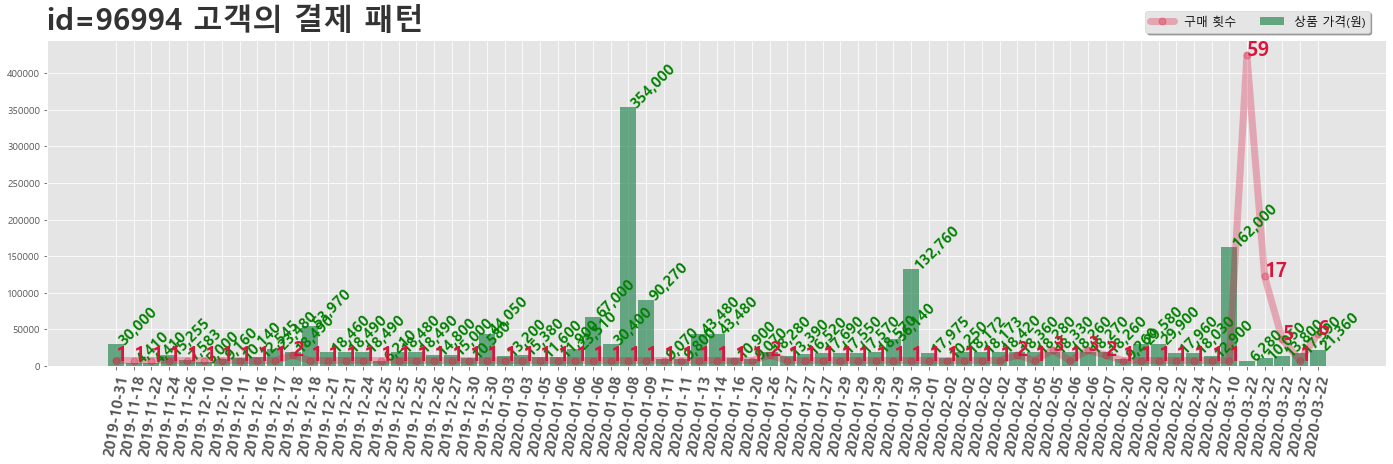

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
498861,498862,28,0,1,1,1993-09-06,2019-11-28 10:55:01.076,2019-11-28,17430846,17242586,52943,188260,241203,0.3,1.1,1.4,1,1013,44,2.58


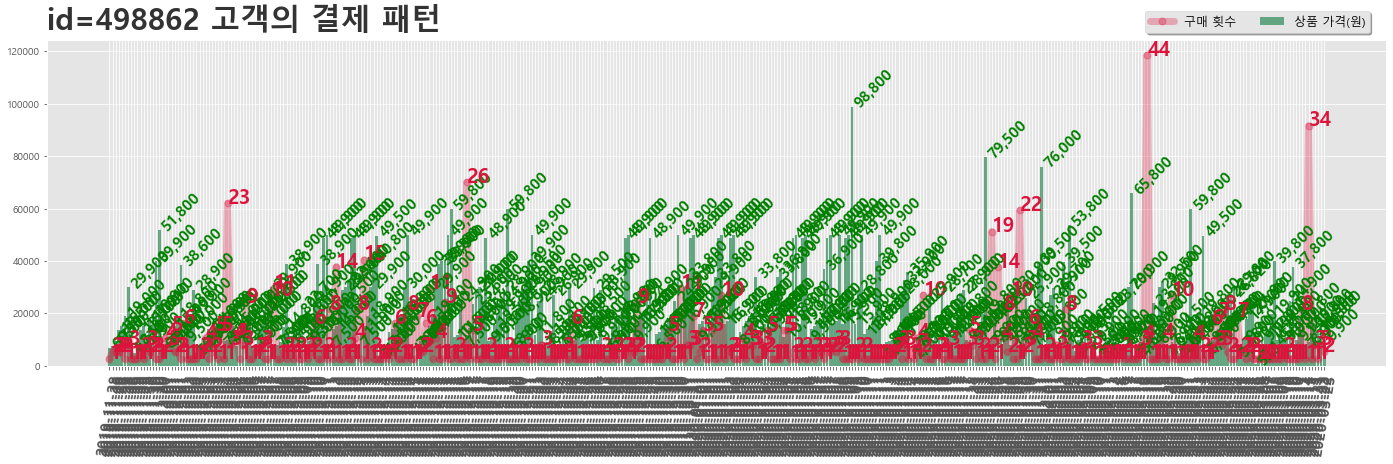

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
305343,305344,51,1,1,0,1970-12-15,2019-07-22 12:01:37.126,2019-07-22,1196630,1108760,0,87870,87870,0.0,7.3,7.3,1,59,34,5.36


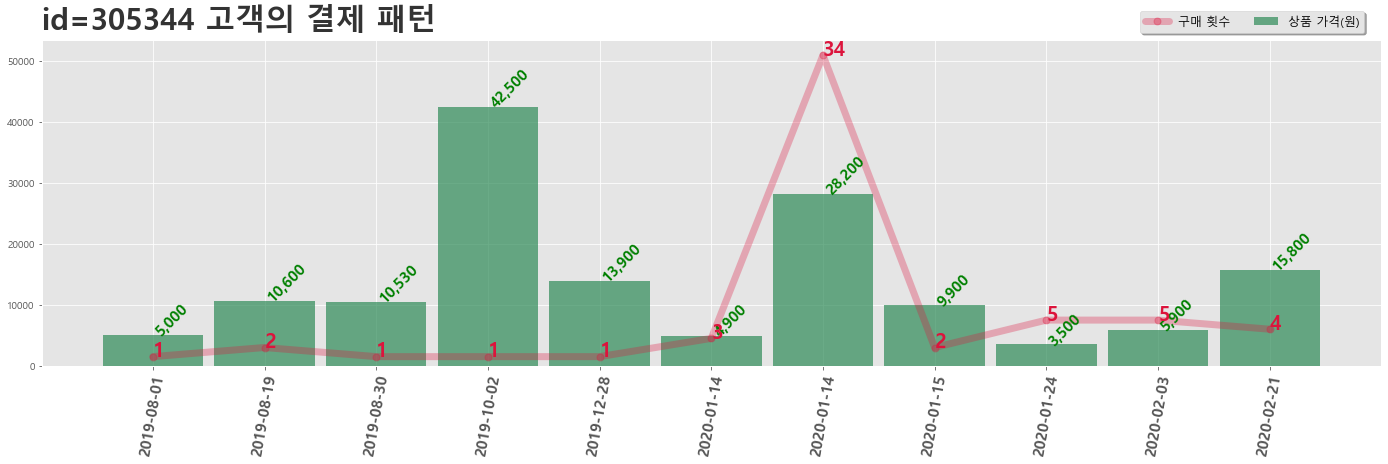

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
12198,12199,37,1,1,0,1984-07-03,2019-10-28 01:08:05.992,2019-10-28,1260087,1238167,39115,21920,61035,3.1,1.7,4.8,1,59,33,2.27


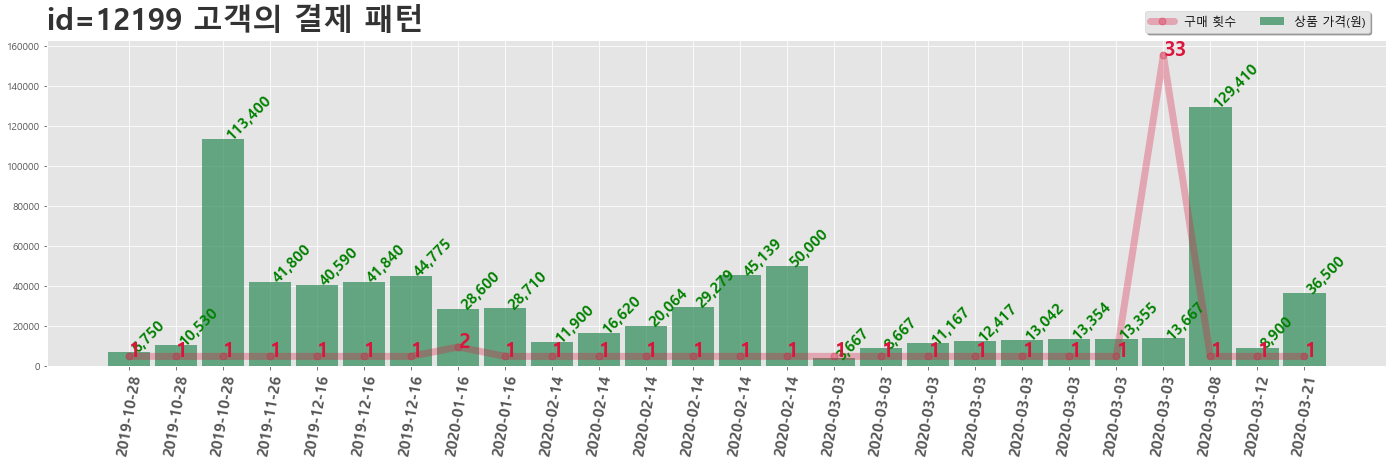

In [13]:
### 반복결제 최댓값 상위 5명
for i in case1:
    patt(i)

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
460469,460470,38,1,0,0,1983-03-02,2019-12-23 00:38:57.703,2019-12-23,13090000,12810000,0,280000,280000,0.0,2.1,2.1,1,14,14,14.0


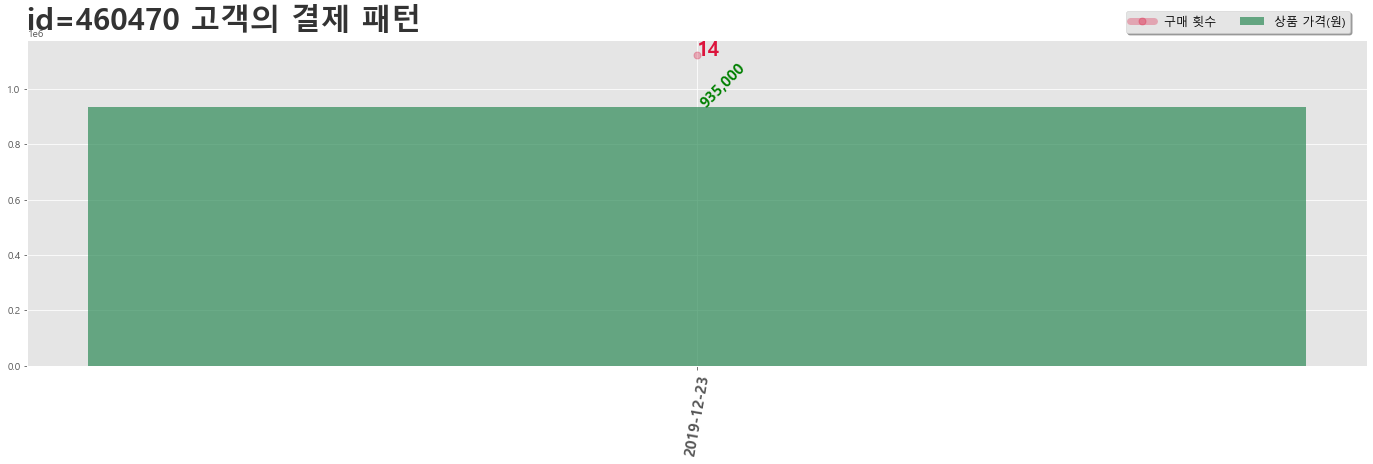

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
356378,356379,33,1,0,0,1988-02-09,2019-12-23 12:01:48.306,2019-12-23,6077500,5947500,0,130000,130000,0.0,2.1,2.1,1,45,25,11.25


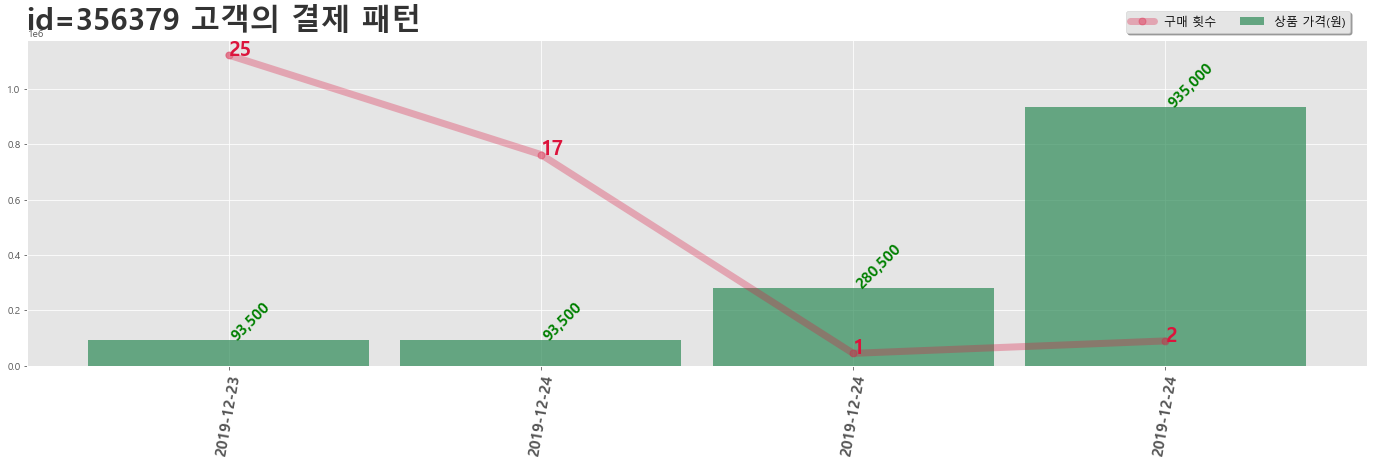

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
302746,302747,39,1,1,0,1982-07-26,2020-01-14 01:56:57.603,2020-01-14,574210,552210,510,22000,22510,0.1,3.8,3.9,1,21,20,10.5


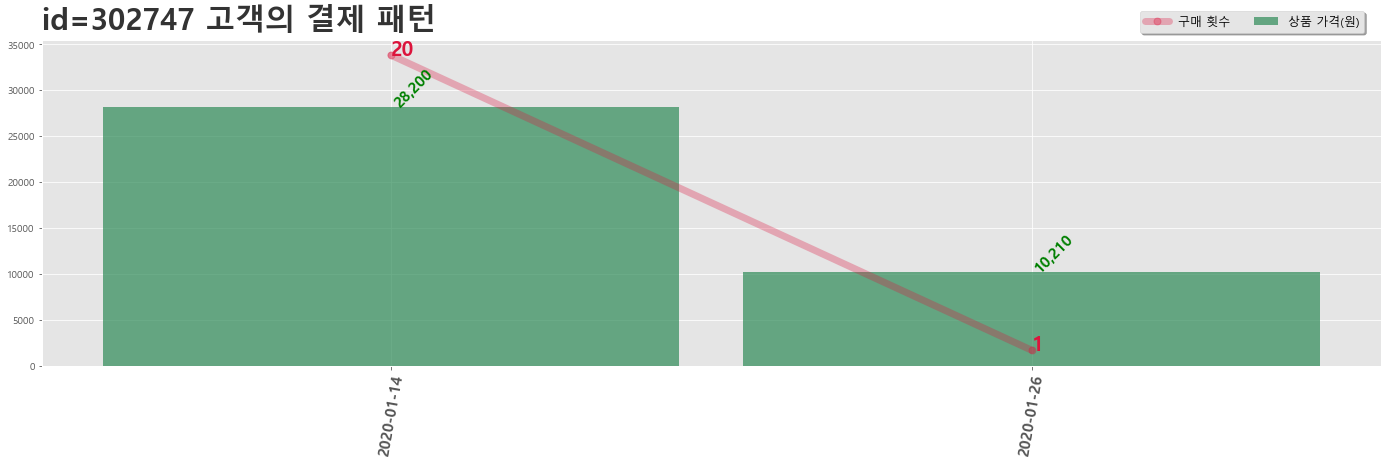

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
411488,411489,37,0,0,0,1984-09-05,2019-12-24 12:35:03.036,2019-12-24,1875000,1830000,0,45000,45000,0.0,2.4,2.4,1,21,20,10.5


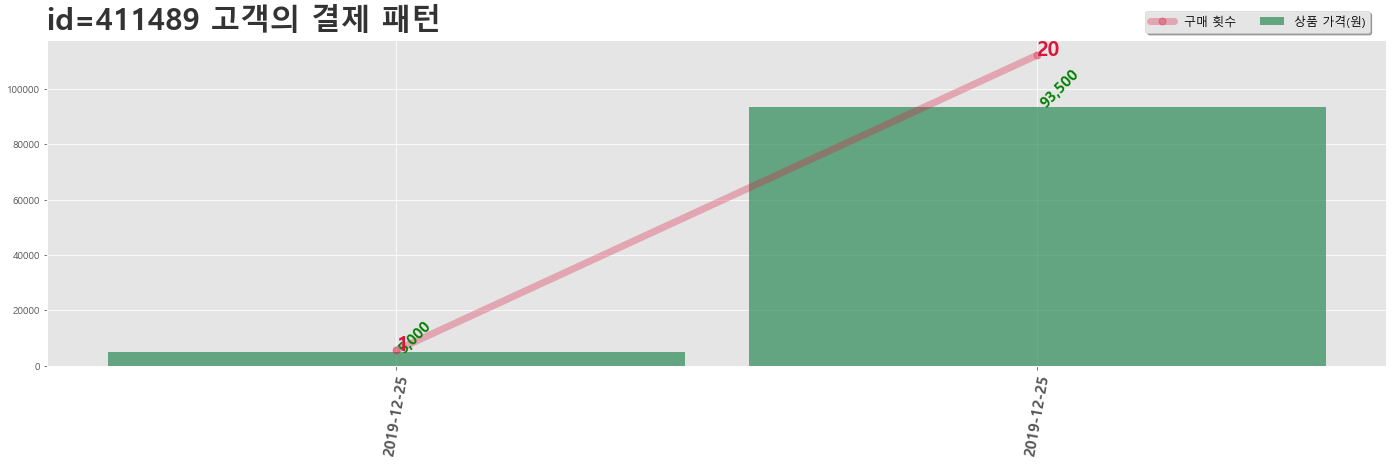

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean
442192,442193,40,1,1,0,1981-12-11,2020-01-13 16:51:43.617,2020-01-13,282000,271500,0,10500,10500,0.0,3.7,3.7,1,10,10,10.0


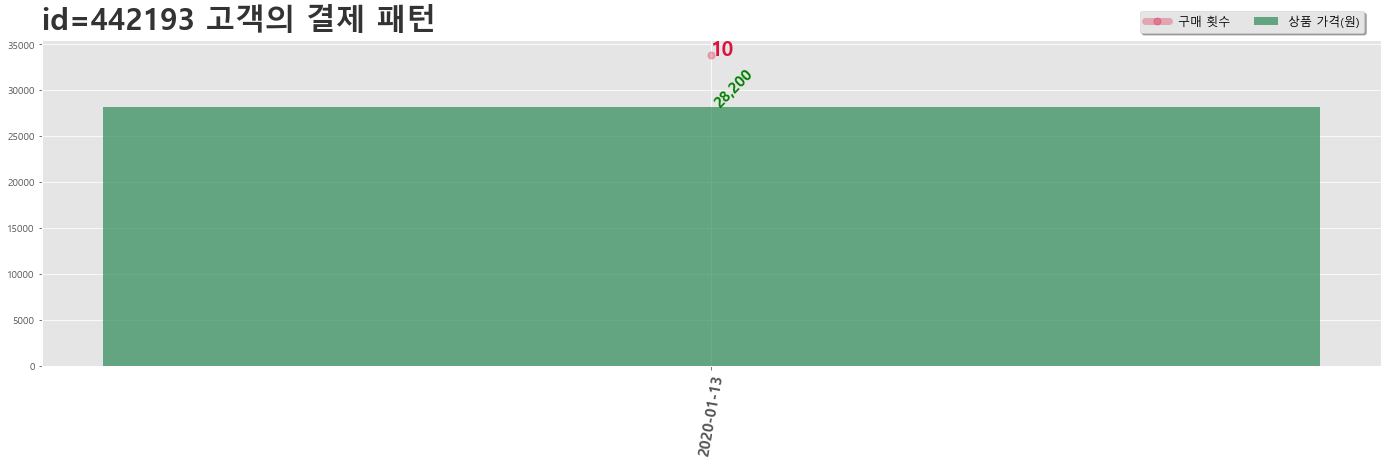

In [14]:
### 반복결제 평균값 상위 5명
for i in case2:
    patt(i)

In [15]:
cost = 28200
print(len(df1.loc[df1.pre==cost,'cnt_b']))

10267


In [16]:
case_93500 = []
for i in range(1,22):
    case_93500.append(i*93500)

for i in case_93500:
    print(f"{i:,} 원짜리 상품 판매 갯수 ---> {len(df1.loc[df1.pre==i,'cnt_b']):,}")

93,500 원짜리 상품 판매 갯수 ---> 6,947
187,000 원짜리 상품 판매 갯수 ---> 1,196
280,500 원짜리 상품 판매 갯수 ---> 1,013
374,000 원짜리 상품 판매 갯수 ---> 445
467,500 원짜리 상품 판매 갯수 ---> 1,579
561,000 원짜리 상품 판매 갯수 ---> 208
654,500 원짜리 상품 판매 갯수 ---> 168
748,000 원짜리 상품 판매 갯수 ---> 162
841,500 원짜리 상품 판매 갯수 ---> 269
935,000 원짜리 상품 판매 갯수 ---> 6,441
1,028,500 원짜리 상품 판매 갯수 ---> 0
1,122,000 원짜리 상품 판매 갯수 ---> 0
1,215,500 원짜리 상품 판매 갯수 ---> 0
1,309,000 원짜리 상품 판매 갯수 ---> 2
1,402,500 원짜리 상품 판매 갯수 ---> 0
1,496,000 원짜리 상품 판매 갯수 ---> 0
1,589,500 원짜리 상품 판매 갯수 ---> 0
1,683,000 원짜리 상품 판매 갯수 ---> 0
1,776,500 원짜리 상품 판매 갯수 ---> 0
1,870,000 원짜리 상품 판매 갯수 ---> 0
1,963,500 원짜리 상품 판매 갯수 ---> 0


### 2_사재기 유발 상품 규명

In [17]:
### 제일 많이 팔리는 상품가
data = df1[["pre","cnt_b"]].groupby("pre").sum()
data = data.sort_values(by="cnt_b",ascending=False).reset_index()

print(data.shape)
data.head(5)

(69956, 2)


,pre,cnt_b
0,9900,161414
1,5900,90899
2,8910,88127
3,7900,81148
4,4900,71423


27


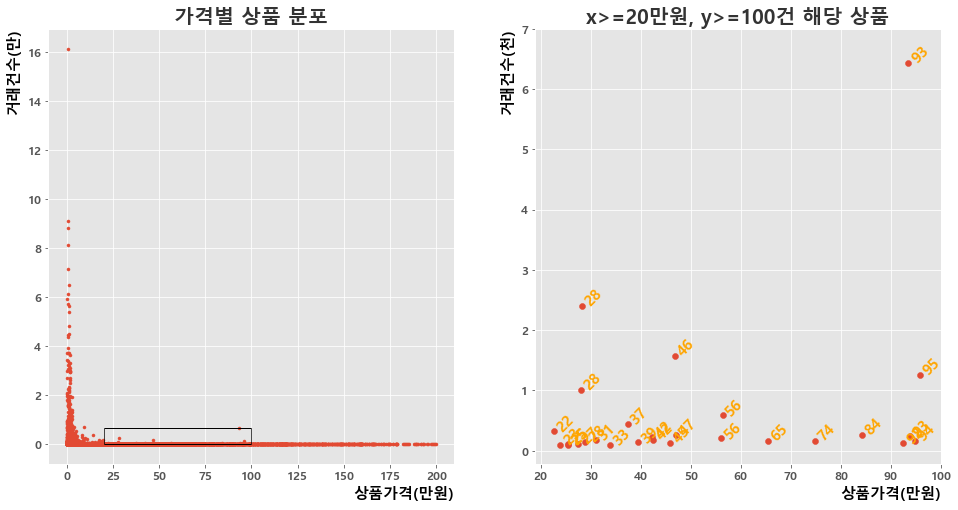

In [18]:
### 차트1) 전체 data
x1, y1 = data.pre, data.cnt_b

### 차트2) 25만원 이상 상품, 판매량 100건 이상
data_focus = data.loc[ (data.pre>=200000) & (data.cnt_b>=100) ]
data_focus = data_focus.reset_index(drop=True)
x2, y2 = data_focus.pre, data_focus.cnt_b
x_ex = [i//10000 for i in x2]
print(len(data_focus))

### 그리기
plt.figure(figsize=((16,8)))
plt.subplot(1,2,1)
plt.scatter(x1,y1, s=3**2)
x_name = range(0,2200000,250000)
plt.xticks(x_name,[i for i in range(0,225,25)], size=12, rotation=0, weight=1000, )
y_name = range(0,200000,20000)
plt.yticks(y_name,[i for i in range(0,20,2)], size=12, rotation=0, weight=1000, )
plt.xlabel("상품가격(만원)", weight=1000, color="k", size=15, rotation=0, loc="right", )
plt.ylabel("거래건수(만)",   weight=1000, color="k", size=15, rotation=90, loc="top",   )
plt.hlines(100, 200000, 1000000, color='k', linestyle='solid', linewidth=1)
plt.hlines(6500, 200000, 1000000, color='k', linestyle='solid', linewidth=1)
plt.vlines(200000, 100, 6500, color='k', linestyle='-', linewidth=1, alpha=0.7)
plt.vlines(1000000, 100, 6500, color='k', linestyle='-', linewidth=1, alpha=0.7)
plt.title("가격별 상품 분포", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )

plt.subplot(1,2,2)
plt.scatter(x2,y2)
plt.title("x>=20만원, y>=100건 해당 상품", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )
N = len(data_focus)
[plt.text(x2[i],y2[i],x_ex[i], size=15, color="orange", weight=1000, rotation=45) for i in range(N)]
x_name = range(200000,1100000,100000)
plt.xticks(x_name,[i for i in range(20,110,10)], size=12, rotation=0, weight=1000, )
y_name = range(0,8000,1000)
plt.yticks(y_name,[i for i in range(0,8,1)], size=12, rotation=0, weight=1000, )
plt.xlabel("상품가격(만원)", weight=1000, color="k", size=15, rotation=0, loc="right", )
plt.ylabel("거래건수(천)",   weight=1000, color="k", size=15, rotation=90, loc="top",   )
plt.show()

In [19]:
### 100건 이상 많이 팔리는 20만원 이상 고가 상품 ---> 27종
case = set(data_focus.pre)
print(len(case))

27


In [20]:
### 93,500 배수 금액 리스트 ----> 8개
A = set([93500*i for i in range(1,22)])
case & A

{280500, 374000, 467500, 561000, 654500, 748000, 841500, 935000}

In [21]:
### 28,200 배수 금액 리스트 ----> 9개
B = set([28200*i for i in range(1,71)])
case & B

{225600, 253800, 282000, 310200, 338400, 394800, 423000, 564000, 958800}

In [22]:
### 인기상품중 93,500 / 28,200 관계없는 금액들
C = sorted((case-A)-B)
print(len(C), C)

10 [239000, 255000, 275400, 289000, 425000, 459000, 470000, 925000, 938400, 948600]


In [23]:
### 배수관계 있는지 최소공배수 확인
from math import gcd

for i in C:
    print([f"{gcd(i,j) if i!=j else 0}".rjust(6) for j in C])

['     0', '  1000', '   200', '  1000', '  1000', '  1000', '  1000', '  1000', '   200', '   200']
['  1000', '     0', ' 10200', ' 17000', ' 85000', ' 51000', '  5000', '  5000', ' 10200', ' 10200']
['   200', ' 10200', '     0', '  3400', '  3400', ' 91800', '   200', '   200', ' 10200', ' 30600']
['  1000', ' 17000', '  3400', '     0', ' 17000', ' 17000', '  1000', '  1000', '  3400', '  3400']
['  1000', ' 85000', '  3400', ' 17000', '     0', ' 17000', '  5000', ' 25000', '  3400', '  3400']
['  1000', ' 51000', ' 91800', ' 17000', ' 17000', '     0', '  1000', '  1000', ' 10200', ' 30600']
['  1000', '  5000', '   200', '  1000', '  5000', '  1000', '     0', '  5000', '   400', '   200']
['  1000', '  5000', '   200', '  1000', ' 25000', '  1000', '  5000', '     0', '   200', '   200']
['   200', ' 10200', ' 10200', '  3400', '  3400', ' 10200', '   400', '   200', '     0', ' 10200']
['   200', ' 10200', ' 30600', '  3400', '  3400', ' 30600', '   200', '   200', ' 10200', 

In [24]:
candi = [10200, 17000]

for i in candi:
    result = set(C) & set([i*k for k in range(1,101)])
    print(f"{i:,} 금액의 배수중 C집합에 있는 상품수: {len(result)}개 --> {sorted(result)}")

10,200 금액의 배수중 C집합에 있는 상품수: 5개 --> [255000, 275400, 459000, 938400, 948600]
17,000 금액의 배수중 C집합에 있는 상품수: 4개 --> [255000, 289000, 425000, 459000]


In [25]:
candi = [93500, 28200, 10200, 17000]
R = case

for i in candi:
    result = case & set([i*k for k in range(1,101)])
    print(f"{i:,} 금액의 배수중 C집합에 있는 상품수: {len(result)}개 ---> {sorted(result)}")
    R = R-result

print(f"\n사재기 인기상품 case 27 종류 중, {len(R)}개 남음 -------> {sorted(R)}")

93,500 금액의 배수중 C집합에 있는 상품수: 8개 ---> [280500, 374000, 467500, 561000, 654500, 748000, 841500, 935000]
28,200 금액의 배수중 C집합에 있는 상품수: 9개 ---> [225600, 253800, 282000, 310200, 338400, 394800, 423000, 564000, 958800]
10,200 금액의 배수중 C집합에 있는 상품수: 7개 ---> [255000, 275400, 459000, 561000, 938400, 948600, 958800]
17,000 금액의 배수중 C집합에 있는 상품수: 8개 ---> [255000, 289000, 374000, 425000, 459000, 561000, 748000, 935000]

사재기 인기상품 case 27 종류 중, 3개 남음 -------> [239000, 470000, 925000]


In [26]:
### 배수관계 있는지 최소공배수 확인
for i in candi:
    print([f"{gcd(i,j) if i!=j else 0}".rjust(6) for j in candi])

['     0', '   100', '  1700', '  8500']
['   100', '     0', '   600', '   200']
['  1700', '   600', '     0', '  3400']
['  8500', '   200', '  3400', '     0']


In [27]:
### 배수관계 있는지 최소공배수 확인
R = [239000, 470000, 925000]

for i in R:
    print([f"{gcd(i,j) if i!=j else 0}".rjust(6) for j in R])

['     0', '  1000', '  1000']
['  1000', '     0', '  5000']
['  1000', '  5000', '     0']


In [28]:
data_focus["Q_93500"] = data_focus["pre"].apply(lambda x: f"{x//93500}" if x%93500==0 else ".")
data_focus["Q_28200"] = data_focus["pre"].apply(lambda x: f"{x//28200}" if x%28200==0 else ".")
data_focus["Q_10200"] = data_focus["pre"].apply(lambda x: f"{x//10200}" if x%10200==0 else ".")
data_focus["Q_17000"] = data_focus["pre"].apply(lambda x: f"{x//17000}" if x%17000==0 else ".")
data_focus = data_focus.reset_index(drop=True)
data_focus

,pre,cnt_b,Q_93500,Q_28200,Q_10200,Q_17000
0,935000,6441,10,.,.,55
1,282000,2405,.,10,.,.
2,467500,1579,5,.,.,.
3,958800,1263,.,34,94,.
4,280500,1013,3,.,.,.
5,564000,588,.,20,.,.
6,374000,445,4,.,.,22
7,225600,319,.,8,.,.
8,841500,269,9,.,.,.
9,470000,253,.,.,.,.


In [29]:
### 씨앗상품 들의 단품 판매 건수도 많은가?
lst = [93500,28200,10200,17000,187000]

for i in lst:
    print( i, "--->", len(df1.loc[df1.pre==i]))

93500 ---> 6947
28200 ---> 10267
10200 ---> 2680
17000 ---> 5399
187000 ---> 1196


In [30]:
### 보따리 상품 27종 구매한 사람 체킹
df1["case27"] = df1.pre.apply(lambda x:1 if x in case else 0)
temp = df1[["id","case27"]].groupby("id").max().reset_index()
df3 = pd.merge( df3, temp, how="left", on="id" )
df3

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.00,0
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.00,0
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,2019-08-24,18120,13440,0,4680,4680,0.0,25.8,25.8,1,1,1,1.00,0
3,4,35,1,1,0,1986-10-18,2019-07-27 20:35:40.581,2019-07-27,227640,216980,0,10660,10660,0.0,4.7,4.7,1,8,1,1.00,0
4,5,44,0,1,0,1977-05-26,2020-01-11 12:28:23.167,2020-01-11,65170,55170,0,10000,10000,0.0,15.3,15.3,1,6,1,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544916,544917,27,0,0,0,1994-07-08,2019-08-11 01:56:44.713,2019-08-11,41220,34740,0,6480,6480,0.0,15.7,15.7,1,2,1,1.00,0
544917,544918,23,0,1,0,1998-02-26,2019-12-08 12:28:08.093,2019-12-08,268665,252665,2296,16000,18296,0.9,6.0,6.8,1,21,1,1.00,0
544918,544919,41,0,1,0,1980-03-25,2019-08-03 16:06:57.300,2019-08-03,529022,483123,177,45899,46076,0.0,8.7,8.7,1,43,3,1.13,0
544919,544920,49,1,1,0,1972-02-07,2019-08-31 11:02:08.238,2019-08-31,462100,429100,441,33000,33441,0.1,7.1,7.2,1,7,1,1.00,0


### 3_보따리상 특성 추정

In [31]:
### 전체 유저 특성
df300 = df3[['age', 'man', 'push', 'frgn', 'sign_cut', 'pre', 'post', 'c_back', 'dscnt', 'total', 'cnt_b', 'RP_max', 'RP_mean', 'case27']]
infox(   df300   )

◆◆◆ (544921, 14): Total shape ◆◆◆
---(544921, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype   n_uniq  |     Mean      Std    |max-min|  │  min      Q1  median       Q3          max  
 0      age     0      0.0    int64       83  |    36.83    11.58          106  │   15      29      36       42          121  
 1      man     0      0.0    int64        2  |   0.3587   0.4796            1  │    0       0       0        1            1  
 2     push     0      0.0    int64        2  |   0.4186   0.4933            1  │    0       0       0        1            1  
 3     frgn     0      0.0    int64        2  |   0.0058   0.0757            1  │    0       0       0        0            1  
 4      pre     0      0.0    int64  168,111  |  211,107  550,002  115,004,850  │  500  23,800  67,300  206,356  115,005,350  
 5     post     0      0.0    int64  176,425  |  196,438  527,835  112,273,800  │    0  20,140  60,480  191,024  112,273,800

In [32]:
### 보따리 상품 1번이라도 산 사람 -----------> 셋중 둘 남자, 알람 싫은편, 고가 상품 선호(보따리.. 당연), 대부분 반복구매 관심 없다
### (20만원이상 고가이면서, 잘 팔리는 제품)
infox(   df300.loc[df300.case27==1]   )

◆◆◆ (9484, 14): Total shape ◆◆◆
---(9484, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |       Mean        Std    |max-min|  │      min       Q1   median         Q3          max  
 0      age     0      0.0    int64      71  |        38.      10.94          105  │       16       32       37         42          121  
 1      man     0      0.0    int64       2  |     0.6827     0.4654            1  │        0        0        1          1            1  
 2     push     0      0.0    int64       2  |     0.3128     0.4637            1  │        0        0        0          1            1  
 3     frgn     0      0.0    int64       2  |     0.0018     0.0423            1  │        0        0        0          0            1  
 4      pre     0      0.0    int64   6,613  |  1,451,941  2,834,105  114,779,750  │  225,600  467,500  935,000  1,589,500  115,005,350  
 5     post     0      0.0    int64   6,753  |  1,396,467  2,7

In [33]:
### 한상품을 하루에 20번 살만큼 꽂힌 경험있는 유저 ----> 알람 좋아하는 외국인, 거래건수 정말 많고, 따라서 매출도 높다
infox(   df300.loc[df300.RP_max>20]   )

◆◆◆ (19, 14): Total shape ◆◆◆
---(19, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |       Mean        Std   |max-min|  │     min         Q1     median         Q3         max  
 0      age     0      0.0    int64      13  |      36.11      6.189          23  │      28       30.5         37         40          51  
 1      man     0      0.0    int64       2  |     0.5789     0.4937           1  │       0          0          1          1           1  
 2     push     0      0.0    int64       2  |     0.6842     0.4648           1  │       0          0          1          1           1  
 3     frgn     0      0.0    int64       2  |     0.1053     0.3069           1  │       0          0          0          0           1  
 4      pre     0      0.0    int64      19  |  6,857,100  7,650,594  27,107,493  │  79,030  1,267,148  3,114,802  7,419,090  27,186,523  
 5     post     0      0.0    int64      19  |  6,721,667  7

In [34]:
### 거래 횟수가 많은 집단 ---> 여성, 알람 좋아, 셋중 하나 외국인, 보따리상 상품 관심없음
infox(   df300.loc[df300.cnt_b>425]   )

◆◆◆ (20, 14): Total shape ◆◆◆
---(20, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |        Mean        Std   |max-min|  │        min         Q1      median          Q3         max  
 0      age     0      0.0    int64      14  |       33.95      6.852          24  │         25      28.75        31.5       37.75          49  
 1      man     0      0.0    int64       2  |        0.05     0.2179           1  │          0          0           0           0           1  
 2     push     0      0.0    int64       2  |        0.85     0.3571           1  │          0          1           1           1           1  
 3     frgn     0      0.0    int64       2  |        0.35      0.477           1  │          0          0           0           1           1  
 4      pre     0      0.0    int64      20  |  13,890,351  8,950,243  32,021,674  │  3,022,112  6,480,086  12,993,109  19,395,920  35,043,786  
 5     post     0      0

In [35]:
### 거래 횟수가 많은 최상위 집단 ---> 젊은 여성, 알람 좋아, 절반은 외국인, 보따리상 상품 관심없음
infox(   df300.loc[df300.cnt_b>500]   )

◆◆◆ (10, 14): Total shape ◆◆◆
---(10, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |        Mean        Std   |max-min|  │         min          Q1      median          Q3         max  
 0      age     0      0.0    int64       7  |        29.7       2.61          10  │          25          28        29.5          31          35  
 1      man     0      0.0    int64       1  |           0          0           0  │           0           0           0           0           0  
 2     push     0      0.0    int64       1  |           1          0           0  │           1           1           1           1           1  
 3     frgn     0      0.0    int64       2  |         0.5        0.5           1  │           0           0         0.5           1           1  
 4      pre     0      0.0    int64      10  |  21,304,483  6,650,189  21,537,805  │  13,505,981  15,660,912  20,282,792  25,972,130  35,043,786  
 5     post 

In [36]:
### 거래 패턴이 주로 반복구매인 유저 ---> 주로 남성 내국인, 알람설정 싫고, 고가 상품에 관심 많다
infox(   df300.loc[df300.RP_mean>5]   )

◆◆◆ (69, 14): Total shape ◆◆◆
---(69, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |       Mean         Std    |max-min|  │     min       Q1   median         Q3          max  
 0      age     0      0.0    int64      30  |      38.75       11.02           66  │      21       33       38         43           87  
 1      man     0      0.0    int64       2  |     0.6812       0.466            1  │       0        0        1          1            1  
 2     push     0      0.0    int64       2  |     0.3043      0.4601            1  │       0        0        0          1            1  
 3     frgn     0      0.0    int64       1  |          0           0            0  │       0        0        0          0            0  
 4      pre     0      0.0    int64      48  |  5,785,385  18,036,253  110,423,100  │  21,000  253,800  935,000  1,466,000  110,444,100  
 5     post     0      0.0    int64      52  |  5,646,014  17,656,

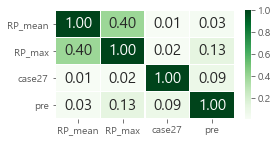

In [37]:
# 파라미터 & 타겟밸류 간 결정계수(=상관계수^2)
plt.figure(figsize=(4, 2))
sns.heatmap(  df300[["RP_mean","RP_max","case27","pre"]].corr()**2, cmap="Greens", linewidths=.5, annot=True, annot_kws={'size':15}, fmt=".2f", )
plt.show()

In [38]:
### 거래 횟수가 많은 집단 ---> 평균나이40, 셋중 2명 남성, 보따리상 상품 관심 매우 많음
infox(   df300.loc[df300.pre>10000000]   )

◆◆◆ (112, 14): Total shape ◆◆◆
---(112, 13): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |        Mean         Std    |max-min|  │         min          Q1      median          Q3          max  
 0      age     0      0.0    int64      40  |       40.51       10.22           51  │          25          34          39          45           76  
 1      man     0      0.0    int64       2  |       0.625      0.4841            1  │           0           0           1           1            1  
 2     push     0      0.0    int64       2  |      0.4643      0.4987            1  │           0           0           0           1            1  
 3     frgn     0      0.0    int64       2  |      0.0536      0.2252            1  │           0           0           0           0            1  
 4      pre     0      0.0    int64     112  |  19,753,075  15,907,173  104,724,350  │  10,281,000  12,338,850  15,026,631  20,245,457  115,00

# 2_군집별 특성 출력하는 시각화 함수

In [39]:
df3.head()

,id,age,man,push,frgn,birth,sign,sign_cut,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,2019-08-25,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,1,1.0,0
1,2,26,0,0,0,1995-07-03,2019-08-09 17:16:59.757,2019-08-09,25030,19359,0,5671,5671,0.0,22.7,22.7,1,2,1,1.0,0
2,3,40,1,1,0,1981-09-09,2019-08-24 16:43:13.693,2019-08-24,18120,13440,0,4680,4680,0.0,25.8,25.8,1,1,1,1.0,0
3,4,35,1,1,0,1986-10-18,2019-07-27 20:35:40.581,2019-07-27,227640,216980,0,10660,10660,0.0,4.7,4.7,1,8,1,1.0,0
4,5,44,0,1,0,1977-05-26,2020-01-11 12:28:23.167,2020-01-11,65170,55170,0,10000,10000,0.0,15.3,15.3,1,6,1,1.0,0


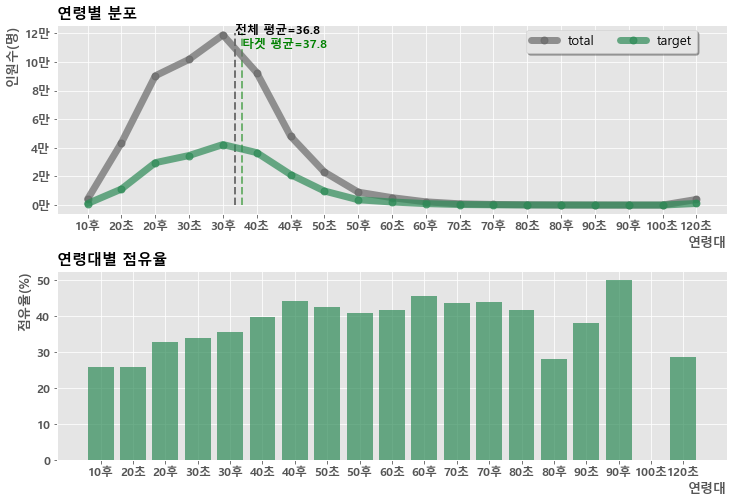

In [7]:
def anal(df):
    data = df[['age','cnt_p',]]
    data["AGE"] = (data["age"]//5)*5
    for i in (set(range(3,25))-{21,22,23}):
        data.loc[f"{i}"] = [0,0,5*i]
    data = data[["AGE","cnt_p"]].groupby("AGE").sum().reset_index()
    data["total"] = [4162, 43560, 90383, 101894, 118992, 92655, 48211, 23120, 9043, 5173, 2250, 868, 425, 177, 82, 21, 2, 1, 3902]
    data["per"] = round(100*data.cnt_p/data.total,1)
    x_mean = round(np.mean(df.age),1)
    x = [5*i for i in range(3,25) if not 21<=i<=23]
    x_ticks = [5*i for i in range(3,22)]
    x_name = ["10후","20초","20후","30초","30후","40초","40후","50초","50후","60초","60후",
                "70초","70후","80초","80후","90초","90후","100초","120초",]
    plt.figure(figsize=((12,8)))
    plt.subplot(9,1,(1,4))
    plt.plot( x_ticks, data.total,      label="total",  alpha=0.7, lw=7, ls="-", color ="DimGray",  marker='o', ms=7, mfc="DimGray",  solid_capstyle='round', )
    plt.plot( x_ticks, data.cnt_p, label="target", alpha=0.7, lw=7, ls="-", color ="seagreen", marker='o', ms=7, mfc="seagreen", solid_capstyle='round', )
    plt.vlines(x_mean, 0, 120000, color='g', linestyle='--', linewidth=2, alpha=0.5)
    plt.vlines(36.8  , 0, 120000, color='k', linestyle='--', linewidth=2, alpha=0.5)
    plt.text(x_mean, 110000, f"타겟 평균={x_mean}", size=12, color="g", weight=1000, )
    plt.text(36.8,   120000, "전체 평균=36.8",      size=12, color="k", weight=1000, )
    plt.xticks( x_ticks, x_name, size=12, weight=1000, rotation=00 )
    plt.yticks( range(0,140000,20000), [f"{i}만" for i in range(0,14,2)], size=12, weight=1000, rotation=0, )
    plt.xlabel( "연령대", weight=1000, size=13, loc="right", )
    plt.ylabel( "인원수(명)", weight=1000, size=13, loc="top", rotation=90, )
    plt.title("연령별 분포", weight=1000, color="k", size=15, loc="left", )
    plt.legend(loc=(0.7,0.85), ncol=2, fontsize=13, frameon=True, shadow=True)
    plt.subplot(9,1,(6,9))
    plt.bar(x_ticks, data.per, color="seagreen", alpha=0.7, width=4, ) # 겹쳐진다
    plt.xticks( x_ticks, x_name, size=12, weight=1000, rotation=00 )
    plt.yticks(    size=12, weight=1000, rotation=0, )
    plt.xlabel( "연령대", weight=1000, size=13, loc="right", )
    plt.ylabel( "점유율(%)", weight=1000, size=13, loc="top", rotation=90, )
    plt.title( "연령대별 점유율", weight=1000, color="k", size=15, loc="left", )
    plt.show()
anal(df3.loc[df3.man==1])

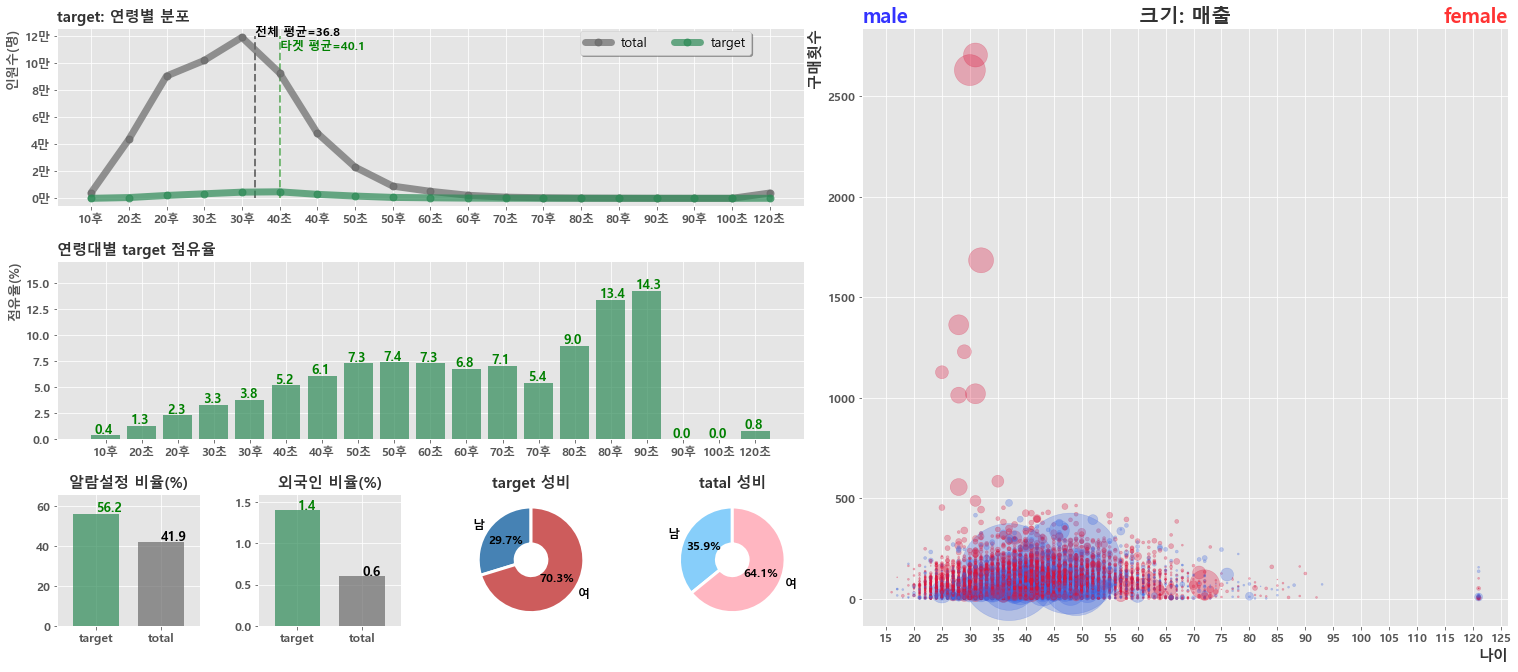

In [111]:
def analysis(df):
    data = df[['age','cnt_p']]
    data["AGE"] = (data["age"]//5)*5
    for i in (set(range(3,25))-{21,22,23}):
        data.loc[f"{i}"] = [0,0,5*i]
    data = data[["AGE","cnt_p"]].groupby("AGE").sum().reset_index()
    data["total"] = [4162, 43560, 90383, 101894, 118992, 92655, 48211, 23120, 9043, 5173, 2250, 868, 425, 177, 82, 21, 2, 1, 3902]
    data["per"] = round(100*data.cnt_p/data.total,1)
    x_mean = round(np.mean(df.age),1)
    x = [5*i for i in range(3,25) if not 21<=i<=23]
    x_ticks = [5*i for i in range(3,22)]
    x_name = ["10후","20초","20후","30초","30후","40초","40후","50초","50후","60초","60후",
                "70초","70후","80초","80후","90초","90후","100초","120초",]
    plt.figure(figsize=((26,11)))
    plt.subplot(13,29,(1,102))
    plt.plot( x_ticks, data.total, label="total",  alpha=0.7, lw=7, ls="-", color ="DimGray",  marker='o', ms=7, mfc="DimGray",  solid_capstyle='round', )
    plt.plot( x_ticks, data.cnt_p, label="target", alpha=0.7, lw=7, ls="-", color ="seagreen", marker='o', ms=7, mfc="seagreen", solid_capstyle='round', )
    plt.vlines(x_mean, 0, 120000, color='g', linestyle='--', linewidth=2, alpha=0.5)
    plt.vlines(36.8  , 0, 120000, color='k', linestyle='--', linewidth=2, alpha=0.5)
    plt.text(x_mean, 110000, f"타겟 평균={x_mean}", size=12, color="g", weight=1000, )
    plt.text(36.8,   120000, "전체 평균=36.8",      size=12, color="k", weight=1000, )
    plt.xticks( x_ticks, x_name, size=12, weight=1000, rotation=00 )
    plt.yticks( range(0,140000,20000), [f"{i}만" for i in range(0,14,2)], size=12, weight=1000, rotation=0, )
    plt.ylabel( "인원수(명)", weight=1000, size=13, loc="top", rotation=90, )
    plt.title("target: 연령별 분포", weight=1000, color="k", size=15, loc="left", alpha=0.8, )
    plt.legend(loc=(0.7,0.85), ncol=2, fontsize=13, frameon=True, shadow=True)

    plt.subplot(13,29,(146,247))
    plt.bar(x_ticks, data.per, color="seagreen", alpha=0.7, width=4, )
    for i in range(19):
        plt.text(x_ticks[i]-1.5,data.per[i]+0.2,data.per[i], size=13, color="g", weight=1000, )
    plt.xticks( x_ticks, x_name, size=12, weight=1000, rotation=00 )
    plt.yticks(    size=12, weight=1000, rotation=0, )
    plt.ylim(0,max(data.per)*1.2)
    plt.ylabel( "점유율(%)", weight=1000, size=13, loc="top", rotation=90, )
    plt.title( "연령대별 target 점유율", weight=1000, color="k", size=15, loc="left", alpha=0.8, )

    N = len(df)
    man_s, push_m, frgn_m = len(df.loc[df.man==1]), round(100*np.mean(df.push),1), round(100*np.mean(df.frgn),1)
    plt.subplot(13,29,(291,351))
    plt.bar(range(2), [push_m,41.9], color=["seagreen","DimGray"], alpha=0.7, width=0.7, )
    plt.xticks( range(2), ["target","total"], size=12, weight=1000, rotation=0 )
    plt.yticks( size=12, weight=1000, rotation=0 )
    plt.title("알람설정 비율(%)", weight=1000, color="k", size=15, alpha=0.8, loc="center", )
    plt.axis([-0.6,1.6,0,max(push_m,41.9)+10])
    plt.text(0,push_m+1,push_m, size=13, color="g", weight=1000, )
    plt.text(1,41.9+1,41.9,     size=13, color="k", weight=1000, )

    plt.subplot(13,29,(295,355))
    plt.bar(range(2), [frgn_m,0.6], color=["seagreen","DimGray"], alpha=0.7, width=0.7, )
    plt.xticks( range(2), ["target","total"], size=12, weight=1000, rotation=0 )
    plt.yticks( size=12, weight=1000, rotation=0 )
    plt.title("외국인 비율(%)", weight=1000, color="k", size=15, alpha=0.8, loc="center", )
    plt.axis([-0.6,1.6,0,max(frgn_m,0.6)+0.2])
    plt.text(0,frgn_m+0.01,frgn_m, size=13, color="g", weight=1000, )
    plt.text(1,0.6+0.01,0.6,     size=13, color="k", weight=1000, )

    plt.subplot(13,29,(299,359))
    x_wedgeprops = {'width':0.7, 'edgecolor':'w', 'linewidth':3}
    x_textprops = {"size":12, "color":"k", "weight":1000, }
    plt.pie([man_s,N-man_s], autopct='%.1f%%', startangle=90, counterclock=True, labels=['남','여'],
            colors=['SteelBlue', 'IndianRed'], wedgeprops=x_wedgeprops, textprops=x_textprops,)
    plt.title("target 성비", weight=1000, color="k", size=15, alpha=0.8, loc="center", )

    plt.subplot(13,29,(303,363))
    plt.pie([195439,349482], autopct='%.1f%%', startangle=90, counterclock=True, labels=['남','여'],
            colors=['LightSkyBlue', 'LightPink'], wedgeprops=x_wedgeprops, textprops=x_textprops,)
    plt.title("tatal 성비", weight=1000, color="k", size=15, alpha=0.8, loc="center", )

    plt.subplot(13,29,(17,377))
    plt.scatter(df.age, df.cnt_b, s=(df.pre.apply(lambda x:1+x//1150053.5))**2, alpha=0.3, c=df.man.apply(lambda x:"RoyalBlue" if x==1 else "Crimson"))
    plt.xticks(range(15,130,5), size=12, rotation=0, weight=1000, )
    plt.yticks( size=12, rotation=0, weight=1000, )
    plt.xlabel("나이",    alpha=0.8, weight=1000, color="k", size=15, rotation=0, loc="right", )
    plt.ylabel("구매횟수", alpha=0.8, weight=1000, color="k", size=15, rotation=90, loc="top",   )
    plt.title("male", weight=1000, color="Blue", size=20, alpha=0.8, pad=-35, loc="left", )
    plt.title("female", weight=1000, color="Red", size=20, alpha=0.8, pad=-35, loc="right", )
    plt.title("크기: 매출", weight=1000, color="k", size=20, alpha=0.8, pad=-35, loc="center", )
    plt.show()

analysis(df3.loc[df3.pre>=1000000])

In [48]:
print(round(100*np.mean(df3.push),1))
print(round(100*np.mean(df3.frgn),1))

41.9
0.6


# 3_feature별 categorical --> grid search

### 전처리1_post 순매출가 수정
- 안쓰이는 post = pre - dscnt 피쳐를 버리지 말고
- 순매출 post = pre - total = pre - (dscnt + cashback) 으로 놓고 활용

In [43]:
### personal data: df9 변수명 이용

df9 = df3[['id', 'age', 'man', 'push', 'frgn', 'pre', 'post', 'c_back', 'dscnt', 'total', 'cnt_p', 'cnt_b', 'RP_max', 'RP_mean', 'case27']]
display(df9.head(2))
infox( df9 )

,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0
1,2,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0


◆◆◆ (544921, 15): Total shape ◆◆◆
---(544921, 15): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype   n_uniq  |     Mean      Std    |max-min|  │  min       Q1   median       Q3          max  
 0       id     0      0.0    int64  544,921  |  272,461  157,305      544,920  │    1  136,231  272,461  408,691      544,921  
 1      age     0      0.0    int64       83  |    36.83    11.58          106  │   15       29       36       42          121  
 2      man     0      0.0    int64        2  |   0.3587   0.4796            1  │    0        0        0        1            1  
 3     push     0      0.0    int64        2  |   0.4186   0.4933            1  │    0        0        0        1            1  
 4     frgn     0      0.0    int64        2  |   0.0058   0.0757            1  │    0        0        0        0            1  
 5      pre     0      0.0    int64  168,111  |  211,107  550,002  115,004,850  │  500   23,800   67,300  206,35

In [44]:
### 유저별 구매력 기준을 ---> 모든 혜택을 제외한 순매출가로 측정
df9["post"] = df9["pre"] - df9["total"]
display(df9.head(1))
infox(df9[["pre","post"]])

,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0


◆◆◆ (544921, 2): Total shape ◆◆◆
---(544921, 2): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)  dtype   n_uniq  |     Mean      Std    |max-min|  │  min      Q1  median       Q3          max  
 0     pre     0      0.0  int64  168,111  |  211,107  550,002  115,004,850  │  500  23,800  67,300  206,356  115,005,350  
 1    post     0      0.0  int64  217,071  |  195,172  525,590  112,273,800  │    0  20,019  60,120  190,050  112,273,800  
------------------------------------------------------------------------------ 



### 전처리2_rank 피쳐 추가
- 1 ~ 544,921 등수가 values 된다.
- feature 로 쓴다기보다는 ---> 순매출 N등 유저 샘플 뽑을 때 인덱싱 유용

In [45]:
### 새로운 피쳐 ---> 매출(pre) 기준 Rank ( 1 ~ 544,921 매출 등수 )

df9 = df9.sort_values(by=["pre","total"],ascending=[False,True]).reset_index(drop=True).reset_index()
df9 = df9.rename(columns={"index":"pre_rank"})
df9["pre_rank"] = df9["pre_rank"] + 1    # (index는 0부터 시작하기 때문에)

print(df9.shape)
display(df9.head(3))
display(df9.tail(3))

df9 = df9.sort_values(by="id").reset_index(drop=True) ## 정렬 ---> 다시 id 순 복구
display(df9.head(2))

(544921, 16)


,pre_rank,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,377381,48,1,1,0,115005350,112273800,0,2731550,2731550,1,175,11,5.00,1
1,2,94844,37,1,1,0,110444100,108245507,150093,2048500,2198593,1,133,11,9.50,1
2,3,38481,49,1,1,0,76952000,75176900,0,1775100,1775100,1,83,13,6.38,1


,pre_rank,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
544918,544919,455073,42,1,0,0,500,500,0,0,0,1,1,1,1.0,0
544919,544920,280054,36,1,0,0,500,490,10,0,10,1,1,1,1.0,0
544920,544921,177657,29,0,1,0,500,485,15,0,15,1,1,1,1.0,0


,pre_rank,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
0,406355,1,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0
1,402172,2,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0


In [46]:
### 새로운 피쳐 ---> 구매횟수(cnt_b) 기준 Rank ( 1 ~ 544,921 cnt_b 등수 )

df9 = df9.sort_values(by=["cnt_b","pre","total"],ascending=[False,False,True]).reset_index(drop=True).reset_index()
df9 = df9.rename(columns={"index":"cnt_rank"})
df9["cnt_rank"] = df9["cnt_rank"] + 1    # (index는 0부터 시작하기 때문에)

print(df9.shape)
display(df9.head(3))
display(df9.tail(3))

df9 = df9.sort_values(by="id").reset_index(drop=True) ## 정렬 ---> 다시 id 순 복구
display(df9.head(2))

(544921, 17)


,cnt_rank,pre_rank,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
0,1,16,45419,31,0,1,0,27186523,26532991,131680,521852,653532,1,2705,21,1.74,0
1,2,8,445691,30,0,1,0,35043786,34231014,216690,596082,812772,1,2630,19,1.79,0
2,3,14,485910,32,0,1,0,27831148,27077318,158163,595667,753830,1,1684,10,1.29,0


,cnt_rank,pre_rank,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
544918,544919,544919,455073,42,1,0,0,500,500,0,0,0,1,1,1,1.0,0
544919,544920,544920,280054,36,1,0,0,500,490,10,0,10,1,1,1,1.0,0
544920,544921,544921,177657,29,0,1,0,500,485,15,0,15,1,1,1,1.0,0


,cnt_rank,pre_rank,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27
0,358798,406355,1,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0
1,357324,402172,2,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0


### 전처리3_외부 피쳐 추가하기

In [47]:
### 외부 피쳐 불러오기
df_ke    = pd.read_parquet( "data\df2_ke.parquet"    )
df_score = pd.read_parquet( "data\df2_score.parquet" )

print( df_ke.shape, df_score.shape )
display(df_ke.head(1))
display(df_score.head(1))

(544921, 24) (544921, 18)


,id,age,man,push,frgn,birth,sign,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,diff_lf,sleep_t,velocity,pur_mass,kn,pur_mass_p,kn_p
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,2,217,1.00926,8.255105,8.331547,8.471611,8.550059


,id,age,man,push,frgn,birth,sign,pre,post,c_back,dscnt,total,c_back_R,dscnt_R,total_R,cnt_p,cnt_b,score
0,1,35,0,0,0,1986-03-26,2019-08-25 18:28:34.815,24330,18960,0,5370,5370,0.0,22.1,22.1,1,2,26.5


In [48]:
### 외부 피쳐 합치기
df_ke    = df_ke[["id","kn","kn_p"]]
df_score = df_score[["id","score"]]
df9 = pd.merge( df9, df_ke, how="left", on="id"    )
df9 = pd.merge( df9, df_score, how="left", on="id" )

display(df9.head(2))
infox( df9[["RP_max","RP_mean","case27","kn","kn_p","score"]] )

,cnt_rank,pre_rank,id,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27,kn,kn_p,score
0,358798,406355,1,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0,8.331547,8.550059,26.5
1,357324,402172,2,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0,10.278356,10.555472,25.5


◆◆◆ (544921, 6): Total shape ◆◆◆
---(544921, 6): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype   n_uniq  |    Mean     Std  |max-min|  │     min     Q1  median     Q3    max  
 0   RP_max     0      0.0    int64       34  |   1.172  0.5701         62  │       1      1       1      1     63  
 1  RP_mean     0      0.0  float64      238  |   1.032  0.1634         13  │       1      1       1      1     14  
 2   case27     0      0.0    int64        2  |  0.0174  0.1308          1  │       0      0       0      0      1  
 3       kn     0      0.0  float64  440,348  |   29.96   20.96      136.3  │  0.4132  12.68   26.13   44.1  136.7  
 4     kn_p     0      0.0  float64  440,349  |   30.26   21.04      135.7  │   1.171  12.92   26.45  44.46  136.9  
 5    score     0      0.0  float64      373  |   33.19   9.696       46.8  │    14.5   25.5    32.5   39.5   61.3  
---------------------------------------------------------------------

### 전처리4_age

In [49]:
""" 1) 나이: 5년 기준 -----> 30대 초반, 30대 후반 """

df9["AGE"] = (df9["age"]//5)*5
df9 = df9[['cnt_rank', 'pre_rank', 'id',  'AGE', 'age', 'man', 'push', 'frgn',
        'pre','post', 'c_back', 'dscnt', 'total', 'cnt_p', 'cnt_b', 'RP_max','RP_mean', 'case27', 'kn', 'kn_p', 'score',]]

display(df9.head(2))
infox( df9[["AGE","age"]] ) #---- 5년 간격 19개 계급

,cnt_rank,pre_rank,id,AGE,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27,kn,kn_p,score
0,358798,406355,1,35,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0,8.331547,8.550059,26.5
1,357324,402172,2,25,26,0,0,0,25030,19359,0,5671,5671,1,2,1,1.0,0,10.278356,10.555472,25.5


◆◆◆ (544921, 2): Total shape ◆◆◆
---(544921, 2): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)  dtype  n_uniq  |   Mean    Std  |max-min|  │  min  Q1  median  Q3  max  
 0     AGE     0      0.0  int64      19  |  34.84  11.72        105  │   15  25      35  40  120  
 1     age     0      0.0  int64      83  |  36.83  11.58        106  │   15  29      36  42  121  
------------------------------------------------------------------------------ 



### 전처리5_labeling

In [50]:
""" 순매출, 구매횟수 따라 4개 등급으로 구분""" #----- 맨 아래 부록

### 매출 상위 0.01%, 8%, 42% 커트라인
### 횟수 상위 0.01%, 9%, 43% 커트라인

N = len(df3)
print( N//10000, N*8//100, N*42//100 ) #--- 매출
print( N*9//100, N*43//100 ) #------------- 거래횟수

54 43593 228866
49042 234316


In [51]:
df9["PRE_1"] = df9["pre_rank"].apply(lambda x:1 if x<=54 else 0)
df9["PRE_2"] = df9["pre_rank"].apply(lambda x:1 if 54<x<=43593 else 0)
df9["PRE_3"] = df9["pre_rank"].apply(lambda x:1 if 43593<x<=228866 else 0)
df9["PRE_4"] = df9["pre_rank"].apply(lambda x:1 if 228866<x else 0)

df9["CNT_1"] = df9["cnt_rank"].apply(lambda x:1 if x<=54 else 0)
df9["CNT_2"] = df9["cnt_rank"].apply(lambda x:1 if 54<x<=49042 else 0)
df9["CNT_3"] = df9["cnt_rank"].apply(lambda x:1 if 49042<x<=234316 else 0)
df9["CNT_4"] = df9["cnt_rank"].apply(lambda x:1 if 234316<x else 0)

df9.head(1)

,cnt_rank,pre_rank,id,AGE,age,man,push,frgn,pre,post,c_back,dscnt,total,cnt_p,cnt_b,RP_max,RP_mean,case27,kn,kn_p,score,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4
0,358798,406355,1,35,35,0,0,0,24330,18960,0,5370,5370,1,2,1,1.0,0,8.331547,8.550059,26.5,0,0,0,1,0,0,0,1


In [52]:
print(round(np.sum(df9.sort_values(by="pre_rank").head(54)["pre"])*100/np.sum(df3.pre),2))      #  상위 0.01% ---> 매출 점유율: 1.29% -----> 대략 x 129
print(round(np.sum(df9.sort_values(by="cnt_rank").head(54)["cnt_b"])*100/np.sum(df3.cnt_b),2))  #  상위 0.01% ---> 매출 점유율: 0.56% -----> 대략 x 56

1.29
0.56


In [53]:
cols = ['cnt_rank', 'pre_rank', 'id', 'AGE', 'age', 'man', 'push', 'frgn', 'cnt_p', 'cnt_b',
        'pre','post','c_back','dscnt','total',
        'RP_max','RP_mean','case27','kn','kn_p','score',
        'PRE_1', 'PRE_2', 'PRE_3','PRE_4', 'CNT_1', 'CNT_2', 'CNT_3', 'CNT_4',]
df9 = df9[cols]
df9.head(1)

,cnt_rank,pre_rank,id,AGE,age,man,push,frgn,cnt_p,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4
0,358798,406355,1,35,35,0,0,0,1,2,24330,18960,0,5370,5370,1,1.0,0,8.331547,8.550059,26.5,0,0,0,1,0,0,0,1


In [54]:
### 개인별 data 저장
df9.to_parquet( "data\df9.parquet", engine="pyarrow", compression='gzip' )

# 4_독립변수 범주화(category)

### 1_역 추적 (pre, cnt_b) --> (age,sex,push,frgn)

In [55]:
cols = ['cnt_p','age', 'man', 'push', 'frgn', 'RP_max', 'RP_mean','case27', 'kn', 'kn_p', 'score',
       'cnt_b', 'pre', 'post', 'c_back', 'dscnt', 'total',
       'PRE_1', 'PRE_2', 'PRE_3', 'PRE_4','CNT_1', 'CNT_2', 'CNT_3', 'CNT_4',]
df_1 = df9[cols].groupby(["PRE_1","PRE_2","PRE_3","PRE_4","CNT_1","CNT_2","CNT_3","CNT_4"]).sum()
df_1

cnt_p       age     man  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                             
0     0     0     1     0     0     0     1      277924  10227352  105033   
                                    1     0       38131   1396614   14345   
            1     0     0     0     0     1       30599   1067135   15722   
                                    1     0      138112   5038978   43649   
                              1     0     0       16562    630363    3815   
      1     0     0     0     0     0     1        2082     83307    1201   
                                    1     0        9022    338311    4038   
                              1     0     0       32389   1285804    7588   
                        1     0     0     0          46      1966      11   
1     0     0     0     0     0     1     0           9       351       7   
                              1     0     0          37      1591      30   
                        1     0     0     0           8       237       0   

                                                   push  frgn  RP_max  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                         
0     0     0     1     0     0     0     1      107513  1225  285241   
                                    1     0       15573   200   45047   
            1     0     0     0     0     1       11209   122   32006   
                                    1     0       61666   928  173097   
                              1     0     0        8708   157   26460   
      1     0     0     0     0     0     1         707     3    2227   
                                    1     0        4065    58   15046   
                              1     0     0       18617   441   59002   
                        1     0     0     0          36     3     202   
1     0     0     0     0     0     1     0           2     0      41   
                              1     0     0          17     0     217   
                        1     0     0     0           8     4     160   

                                                   RP_mean  case27  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                      
0     0     0     1     0     0     0     1      282864.90       0   
                                    1     0       40056.33       0   
            1     0     0     0     0     1       31523.80    2000   
                                    1     0      143659.65    1446   
                              1     0     0       17283.03      14   
      1     0     0     0     0     0     1        2185.50    1589   
                                    1     0       10358.09    3294   
                              1     0     0       33964.72    1095   
                        1     0     0     0          55.39       2   
1     0     0     0     0     0     1     0          28.71       9   
                              1     0     0         109.65      35   
                        1     0     0     0          13.48       0   

                                                           kn          kn_p  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                               
0     0     0     1     0     0     0     1      4.288086e+06  4.357144e+06   
                                    1     0      1.278330e+06  1.297372e+06   
            1     0     0     0     0     1      6.300929e+05  6.328332e+05   
                                    1     0      6.180034e+06  6.227130e+06   
                              1     0     0      1.039246e+06  1.047987e+06   
      1     0     0     0     0     0     1      4.099598e+04  4.107177e+04   
                                    1     0      4.734784e+05  4.751942e+05   
                              1     0     0      2.387884e+06  2.401995e+06   
                        1     0     0     0      4.750630e+03  4.775700e+03   
1     0     0     0     0     0     1     0      5.224719e+02  5.234873e+02   
                   

In [56]:
### 단위/유효숫자 처리
a = [0, 1, 100,100,100, 1,1, 100, 1,1,1,1,]  # 곱해줄 상수 ---> 백분위 피쳐만 x100
w = [0, 1,   1,  1,  1, 1,1,   1, 1,1,1,1,]  # 유효숫자 갯수
for i in range(1,17):
    if 12<=i:
        df_1.iloc[:,i] = df_1.iloc[:,i]//df_1.iloc[:,0]
    else: df_1.iloc[:,i] = round(a[i]*df_1.iloc[:,i]/df_1.iloc[:,0],w[i])
df_1

cnt_p   age   man   push  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                              
0     0     0     1     0     0     0     1      277924  36.8  37.8   38.7   
                                    1     0       38131  36.6  37.6   40.8   
            1     0     0     0     0     1       30599  34.9  51.4   36.6   
                                    1     0      138112  36.5  31.6   44.6   
                              1     0     0       16562  38.1  23.0   52.6   
      1     0     0     0     0     0     1        2082  40.0  57.7   34.0   
                                    1     0        9022  37.5  44.8   45.1   
                              1     0     0       32389  39.7  23.4   57.5   
                        1     0     0     0          46  42.7  23.9   78.3   
1     0     0     0     0     0     1     0           9  39.0  77.8   22.2   
                              1     0     0          37  43.0  81.1   45.9   
                        1     0     0     0           8  29.6   0.0  100.0   

                                                 frgn  RP_max  RP_mean  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                          
0     0     0     1     0     0     0     1       0.4     1.0      1.0   
                                    1     0       0.5     1.2      1.1   
            1     0     0     0     0     1       0.4     1.0      1.0   
                                    1     0       0.7     1.3      1.0   
                              1     0     0       0.9     1.6      1.0   
      1     0     0     0     0     0     1       0.1     1.1      1.0   
                                    1     0       0.6     1.7      1.1   
                              1     0     0       1.4     1.8      1.0   
                        1     0     0     0       6.5     4.4      1.2   
1     0     0     0     0     0     1     0       0.0     4.6      3.2   
                              1     0     0       0.0     5.9      3.0   
                        1     0     0     0      50.0    20.0      1.7   

                                                 case27     kn   kn_p  score  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                                
0     0     0     1     0     0     0     1         0.0   15.4   15.7   27.4   
                                    1     0         0.0   33.5   34.0   34.1   
            1     0     0     0     0     1         6.5   20.6   20.7   29.4   
                                    1     0         1.0   44.7   45.1   39.4   
                              1     0     0         0.1   62.7   63.3   47.4   
      1     0     0     0     0     0     1        76.3   19.7   19.7   29.4   
                                    1     0        36.5   52.5   52.7   40.2   
                              1     0     0         3.4   73.7   74.2   49.7   
                        1     0     0     0         4.3  103.3  103.8   55.0   
1     0     0     0     0     0     1     0       100.0   58.1   58.2   36.6   
                              1     0     0        94.6   82.8   83.0   42.2   
                        1     0     0     0         0.0  126.5  126.6   54.9   

                                                  cnt_b       pre      post  \
PRE_1 PRE_2 PRE_3 PRE_4 CNT_1 CNT_2 CNT_3 CNT_4                               
0     0     0     1     0     0     0     1         1.8     30527     26806   
                                    1     0         6.5     67969     58604   
            1     0     0     0     0     1         2.3    173343    164816   
                                    1     0        12.8    241240    221838   
                              1     0     0        38.5    471828    427831   
      1     0     0     0     0     0     1         1.9   1122089   1091999   
                                    1     0        16.7   1238823   1186559   
                              1     0     0        68.7   1304546   1211119   
         

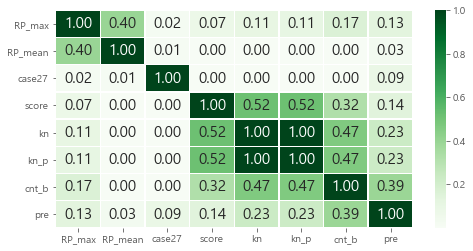

In [57]:
# 파라미터 & 타겟밸류 간 결정계수(=상관계수^2)
plt.figure(figsize=(8, 4))
sns.heatmap(  df9[["RP_max","RP_mean","case27","score","kn","kn_p","cnt_b","pre",]].corr()**2, cmap="Greens", linewidths=.5, annot=True, annot_kws={'size':15}, fmt=".2f", )
plt.show()

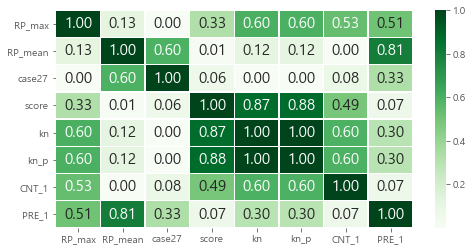

In [75]:
df_1 = df_1.reset_index()

# 파라미터 & 타겟밸류 간 결정계수(=상관계수^2)
plt.figure(figsize=(8, 4))
sns.heatmap(  df_1[["RP_max","RP_mean","case27","score","kn","kn_p","CNT_1","PRE_1",]].corr()**2,
                cmap="Greens", linewidths=.5, annot=True, annot_kws={'size':15}, fmt=".2f", )
plt.show()

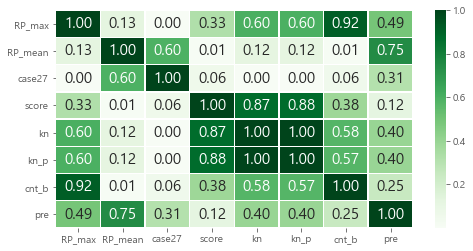

In [59]:
# 파라미터 & 타겟밸류 간 결정계수(=상관계수^2)
plt.figure(figsize=(8, 4))
sns.heatmap(  df_1[["RP_max","RP_mean","case27","score","kn","kn_p","cnt_b","pre",]].corr()**2, cmap="Greens", linewidths=.5, annot=True, annot_kws={'size':15}, fmt=".2f", )
plt.show()

### 2_최소 피쳐: age, man, push, frgn

In [60]:
cols = ['cnt_p','PRE_1', 'PRE_2', 'PRE_3', 'PRE_4','CNT_1', 'CNT_2', 'CNT_3', 'CNT_4',
        'cnt_b', 'pre', 'post', 'c_back', 'dscnt', 'total',
        'RP_max', 'RP_mean','case27', 'kn', 'kn_p', 'score',
        'AGE', 'man', 'push', 'frgn', ]
df_2 = df9[cols].groupby(["AGE","man","push","frgn"]).sum()

print(df_2.shape)
display(df_2)

### 각 유저가 가지는 독립변수 나이대, 성별, 알람, 외국인 여부에 따라 
###                           19  x  2  x 2    x 2 = 152(최대) 그룹으로 나누고 ---> 매출, 횟수 등을 감안해서 그룹으로 묶기

(115, 21)


cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
15  0   0    0       902      0      8    185    709      0     22    224   
        1    0      2190      0     27    612   1551      0     70    796   
    1   0    0       389      0      7     72    310      0      3     63   
        1    0       681      0      9    149    523      0     11    150   
20  0   0    0     17176      0    602   5803  10771      0    921   5728   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
120 0   1    1         6      0      1      0      5      0      0      0   
    1   0    0       882      0     24     89    769      0      4     68   
             1         1      0      0      0      1      0      0      0   
        1    0       233      0      5     17    211      0      2     15   
             1         1      0      0      0      1      0      0      1   

                   CNT_4   cnt_b         pre        post    c_back      dscnt  \
AGE man push frgn                                                               
15  0   0    0       656    4614    64686613    58935645    441910    5309058   
        1    0      1324   14366   199173027   182979680   1282428   14910919   
    1   0    0       323    1335    29882142    27546802    170392    2164948   
        1    0       520    2906    58206664    53684296    248848    4273520   
20  0   0    0     10527  129811  2351111266  2173081254  16213746  161816266   
...                  ...     ...         ...         ...       ...        ...   
120 0   1    1         6       7     1031300     1011499         0      19801   
    1   0    0       810    2034    82108242    74780733       490    7327019   
             1         1       1        7900        2900         0       5000   
        1    0       216     529    13332368    11851969         0    1480399   
             1         0       5       69730       62658         0       7072   

                       total  RP_max   RP_mean  case27             kn  \
AGE man push frgn                                                       
15  0   0    0       5750968     940    915.72       1   19048.553961   
        1    0      16193347    2315   2217.59       3   57237.427806   
    1   0    0       2335340     425    409.61       3    7191.023422   
        1    0       4522368     736    704.02       4   13642.093568   
20  0   0    0     178030012   18397  17372.62      55  468267.205112   
...                      ...     ...       ...     ...            ...   
120 0   1    1         19801       6      6.00       1      40.894158   
    1   0    0       7327509     998    951.46      23    6462.183543   
             1          5000       1      1.00       0       4.894967   
        1    0       1480399     242    237.35       3    1778.760561   
             1          7072       1      1.00       0      19.895501   

                            kn_p     score  
AGE man push frgn                           
15  0   0    0      19262.233005   23828.2  
        1    0      57824.805563   83043.7  
    1   0    0       7291.432199    7947.5  
        1    0      13799.942414   21178.7  
20  0   0    0     472449.744328  487633.2  
...                          ...       ...  
120 0   1    1         42.335648     212.0  
    1   0    0       6827.287174   18687.1  
             1          5.508671      19.5  
        1    0       1878.034760    7239.3  
             1         20.103227      36.5  

[115 rows x 21 columns]

In [61]:
### 단위/유효숫자 처리
a = [0, 100,100,100,100,100,100,100,100, 1, 0,0,0,0,0, 1,1, 100, 1,1,1,]  # 곱해줄 상수 ---> 백분위 피쳐만 x100
w = [0,   1,  1,  1,  1,  1,  1,  1,  1, 1, 0,0,0,0,0, 1,1,   1, 1,1,1,]  # 유효숫자 갯수
for i in range(1,21):
    if 10<=i<=14:
        df_2.iloc[:,i] = df_2.iloc[:,i]//df_2.iloc[:,0]
    else: df_2.iloc[:,i] = round(a[i]*df_2.iloc[:,i]/df_2.iloc[:,0],w[i])
infox(df_2[["cnt_p","pre","case27"]])

◆◆◆ (115, 3): Total shape ◆◆◆
---(115, 3): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)    dtype  n_uniq  |     Mean      Std  |max-min|  │    min       Q1   median       Q3        max  
 0   cnt_p     0      0.0    int64      93  |    4,738    9,762     45,958  │      1       17      152    3,083     45,959  
 1     pre     0      0.0    int64     115  |  254,975  163,381  1,302,417  │  5,200  159,811  243,948  327,971  1,307,617  
 2  case27     0      0.0  float64      44  |    2.017    3.249       18.2  │      0        0      0.9     2.65       18.2  
------------------------------------------------------------------------------ 



In [62]:
### 경우의 수가 115 가지나 된다..
sero(df_2,10)

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
15  0   0    0       902    0.0    0.9   20.5   78.6    0.0    2.4   24.8   
        1    0      2190    0.0    1.2   27.9   70.8    0.0    3.2   36.3   
    1   0    0       389    0.0    1.8   18.5   79.7    0.0    0.8   16.2   
        1    0       681    0.0    1.3   21.9   76.8    0.0    1.6   22.0   
20  0   0    0     17176    0.0    3.5   33.8   62.7    0.0    5.4   33.3   
             1        29    0.0    3.4   31.0   65.5    0.0    6.9   34.5   
        1    0     14982    0.0    4.8   36.9   58.3    0.0    7.2   37.2   
             1       170    0.0   10.6   43.5   45.9    0.0   16.5   49.4   
    1   0    0      6625    0.0    2.7   34.7   62.6    0.0    1.9   22.8   
             1         8    0.0    0.0   37.5   62.5    0.0   12.5   25.0   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
15  0   0    0      72.7    5.1   71714   65338     489   5885   6375     1.0   
        1    0      60.5    6.6   90946   83552     585   6808   7394     1.1   
    1   0    0      83.0    3.4   76817   70814     438   5565   6003     1.1   
        1    0      76.4    4.3   85472   78831     365   6275   6640     1.1   
20  0   0    0      61.3    7.6  136883  126518     943   9421  10365     1.1   
             1      58.6    8.1  141565  131740    1041   8783   9824     1.0   
        1    0      55.6    9.0  159541  147684    1075  10781  11857     1.1   
             1      34.1   16.6  287717  268658    2521  16537  19059     1.2   
    1   0    0      75.3    4.4  131993  123784     831   7377   8209     1.1   
             1      62.5    8.4  107243   98553     218   8471   8690     1.1   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
15  0   0    0         1.0     0.1  21.1  21.4   26.4  
        1    0         1.0     0.1  26.1  26.4   37.9  
    1   0    0         1.1     0.8  18.5  18.7   20.4  
        1    0         1.0     0.6  20.0  20.3   31.1  
20  0   0    0         1.0     0.3  27.3  27.5   28.4  
             1         1.0     0.0  29.2  29.4   29.3  
        1    0         1.0     0.2  29.7  30.0   39.2  
             1         1.0     0.0  39.4  39.7   42.6  
    1   0    0         1.0     2.5  23.1  23.3   21.6  
             1         1.0     0.0  28.9  29.1   22.8

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
20  1   1    0      4554    0.0    3.2   35.0   61.8    0.0    2.6   24.1   
             1        16    0.0    0.0   62.5   37.5    0.0   12.5   68.8   
25  0   0    0     41038    0.0    5.5   34.6   59.8    0.0    7.1   33.8   
             1       152    0.0    9.2   41.4   49.3    0.0   13.2   38.2   
        1    0     19127    0.0    7.5   37.5   54.9    0.0    9.6   36.9   
             1       426    0.7   18.5   43.7   37.1    1.2   20.2   43.9   
    1   0    0     21212    0.0    4.0   33.2   62.7    0.0    3.2   27.0   
             1        29    0.0    0.0   37.9   62.1    0.0    0.0   34.5   
        1    0      8330    0.0    5.3   34.7   60.0    0.0    4.2   29.9   
             1        69    0.0   15.9   37.7   46.4    0.0   13.0   44.9   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
20  1   1    0      73.3    5.1  138415  129607     915   7893   8808     1.1   
             1      18.8   12.1  222874  208481    1349  13043  14392     1.3   
25  0   0    0      59.1    8.6  169677  156914    1037  11724  12762     1.1   
             1      48.7   12.4  248671  232833    1651  14186  15838     1.2   
        1    0      53.6   10.5  202418  187432    1381  13604  14985     1.1   
             1      34.7   29.4  567401  537717    4746  24937  29683     1.5   
    1   0    0      69.8    5.6  153019  142738     886   9394  10281     1.1   
             1      65.5    4.8   94642   86064     144   8433   8578     1.1   
        1    0      65.9    6.6  167460  155980    1201  10278  11480     1.1   
             1      42.0   15.8  371978  347952    4709  19315  24025     1.2   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
20  1   1    0         1.0     1.7  23.6  23.8   32.0  
             1         1.0     6.2  40.1  40.4   37.1  
25  0   0    0         1.0     0.5  29.0  29.3   28.9  
             1         1.0     0.0  34.5  34.7   30.5  
        1    0         1.0     0.5  31.5  31.8   39.8  
             1         1.0     0.5  42.0  42.3   43.0  
    1   0    0         1.0     3.2  24.9  25.2   22.4  
             1         1.0     0.0  20.7  20.9   23.0  
        1    0         1.0     2.6  26.5  26.8   32.9  
             1         1.0     0.0  37.4  37.6   36.6

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
30  0   0    0     45959    0.0    6.8   33.8   59.4    0.0    8.0   34.9   
             1       218    0.0   10.6   39.4   50.0    0.0   15.6   38.5   
        1    0     20579    0.0    9.5   37.1   53.4    0.0   11.2   38.3   
             1       480    0.2   19.6   38.5   41.7    0.4   22.9   40.0   
    1   0    0     25707    0.0    5.0   30.3   64.8    0.0    3.2   29.7   
             1        70    0.0   12.9   28.6   58.6    0.0   11.4   27.1   
        1    0      8750    0.0    6.7   33.2   60.1    0.0    5.5   32.7   
             1       131    0.0   15.3   39.7   45.0    0.0   16.0   38.2   
35  0   0    0     45040    0.0    7.1   34.2   58.7    0.0    8.6   36.3   
             1       149    0.0   13.4   38.3   48.3    0.0   18.1   29.5   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
30  0   0    0      57.1    9.4  185198  170841    1066  13290  14357     1.1   
             1      45.9   14.3  266637  246936    1651  18049  19701     1.2   
        1    0      50.5   12.5  240915  223048    1572  16293  17866     1.2   
             1      36.7   25.6  497618  468023    5321  24273  29594     1.4   
    1   0    0      67.2    5.9  160081  148183     770  11127  11897     1.2   
             1      61.4   11.5  347278  328485    3503  15289  18792     1.2   
        1    0      61.8    7.9  198911  184488    1294  13128  14422     1.2   
             1      45.8   16.7  409708  380617    4554  24537  29091     1.3   
35  0   0    0      55.2   10.1  192868  177453    1114  14300  15414     1.2   
             1      52.3   14.8  265471  245749    2022  17699  19721     1.2   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
30  0   0    0         1.0     1.1  30.0  30.3   30.3  
             1         1.0     0.5  35.1  35.4   32.3  
        1    0         1.0     1.0  33.3  33.6   41.4  
             1         1.0     0.2  42.9  43.2   44.1  
    1   0    0         1.0     4.0  24.7  25.0   23.7  
             1         1.0     2.9  27.8  28.1   25.2  
        1    0         1.0     3.3  27.4  27.7   34.5  
             1         1.0     1.5  36.7  37.0   37.4  
35  0   0    0         1.0     1.1  30.8  31.2   30.6  
             1         1.0     0.0  32.8  33.0   31.8

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
35  0   1    0     31075    0.0   10.7   36.6   52.8    0.0   13.1   37.5   
             1       402    0.0   20.1   37.1   42.8    0.0   24.1   33.1   
    1   0    0     29561    0.0    5.8   30.0   64.2    0.0    4.1   32.2   
             1        71    0.0   11.3   31.0   57.7    0.0    9.9   23.9   
        1    0     12598    0.0    8.0   32.5   59.4    0.0    7.1   34.8   
             1        96    0.0   18.8   29.2   52.1    0.0   13.5   36.5   
40  0   0    0     25401    0.0    9.4   34.1   56.5    0.0   11.2   34.7   
             1        48    0.0   12.5   35.4   52.1    0.0   16.7   35.4   
        1    0     30359    0.0   13.0   36.8   50.2    0.0   15.9   36.1   
             1       166    0.0   22.3   39.2   38.6    0.0   25.9   36.1   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
35  0   1    0      49.4   13.4  248447  229177    1628  17642  19270     1.2   
             1      42.8   21.7  417300  389642    3245  24412  27657     1.2   
    1   0    0      63.7    6.8  181208  167469     770  12969  13739     1.2   
             1      66.2    7.6  221960  205965     918  15076  15995     1.1   
        1    0      58.1    9.0  221315  205095    1299  14920  16219     1.2   
             1      50.0   15.5  323692  304000    2461  17230  19691     1.2   
40  0   0    0      54.1   11.9  226939  208940    1297  16701  17998     1.2   
             1      47.9   15.6  249138  232023    2089  15025  17114     1.4   
        1    0      48.0   15.6  288398  266307    1872  20218  22090     1.2   
             1      38.0   21.2  448392  419843    2917  25631  28549     1.3   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
35  0   1    0         1.0     0.9  34.2  34.5   41.7  
             1         1.0     0.2  41.2  41.4   43.6  
    1   0    0         1.1     4.6  25.6  26.0   24.2  
             1         1.0     2.8  26.3  26.5   24.6  
        1    0         1.0     3.3  28.7  29.0   35.1  
             1         1.0     0.0  34.6  34.8   36.8  
40  0   0    0         1.0     1.1  31.5  31.8   33.0  
             1         1.0     0.0  33.6  33.9   34.3  
        1    0         1.0     0.8  35.2  35.5   44.1  
             1         1.0     1.2  40.4  40.7   45.9

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
40  1   0    0     21839    0.0    6.5   32.0   61.5    0.0    5.6   34.0   
             1        25    0.0    4.0   28.0   68.0    0.0    4.0   32.0   
        1    0     14766    0.0    9.6   34.3   56.0    0.0    9.4   36.3   
             1        51    0.0   13.7   31.4   54.9    0.0   17.6   31.4   
45  0   0    0      9058    0.0   11.2   33.9   54.9    0.0   13.4   33.5   
             1        21    0.0    4.8   38.1   57.1    0.0   14.3   38.1   
        1    0     17684    0.0   14.9   36.7   48.3    0.0   17.9   35.5   
             1        79    0.0   24.1   32.9   43.0    0.0   29.1   31.6   
    1   0    0     10547    0.0    6.8   32.6   60.6    0.0    6.8   33.9   
             1        12    0.0    8.3   41.7   50.0    0.0   16.7   33.3   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
40  1   0    0      60.4    7.9  191742  176743     865  14133  14998     1.2   
             1      64.0    6.6  117462  107724     995   8742   9738     1.1   
        1    0      54.2   10.7  243858  225703    1483  16671  18155     1.2   
             1      51.0   16.1  353673  329070    2802  21800  24603     1.2   
45  0   0    0      53.1   13.2  259677  239740    1497  18439  19936     1.2   
             1      47.6   10.1  185545  168685     704  16155  16860     1.2   
        1    0      46.6   17.4  320595  296490    2035  22069  24104     1.2   
             1      39.2   23.2  462824  433375    4722  24725  29448     1.2   
    1   0    0      59.3    8.6  199330  183857     955  14517  15473     1.2   
             1      50.0   12.5  251495  231188     385  19920  20306     1.1   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
40  1   0    0         1.1     4.1  27.0  27.3   26.7  
             1         1.0     0.0  25.5  25.8   26.0  
        1    0         1.0     2.9  30.5  30.8   37.8  
             1         1.0     0.0  35.8  36.1   38.7  
45  0   0    0         1.0     1.3  32.3  32.6   33.3  
             1         1.0     0.0  33.9  34.2   34.0  
        1    0         1.0     0.8  36.2  36.5   44.5  
             1         1.0     1.3  42.7  43.0   46.0  
    1   0    0         1.1     3.4  27.9  28.2   27.0  
             1         1.0     8.3  32.6  33.0   29.9

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
45  1   1    0     10784    0.0   10.4   34.9   54.6    0.0   11.0   36.0   
             1        26    0.0   15.4   38.5   46.2    0.0   23.1   38.5   
50  0   0    0      3563    0.0   11.7   33.0   55.3    0.0   13.7   32.2   
             1         6    0.0    0.0   33.3   66.7    0.0   16.7   33.3   
        1    0      9659    0.0   17.0   36.8   46.2    0.0   20.5   34.7   
             1        62    0.0   21.0   38.7   40.3    0.0   27.4   37.1   
    1   0    0      3742    0.0    7.7   31.6   60.7    0.0    7.7   34.3   
             1         4    0.0   25.0   25.0   50.0    0.0    0.0   50.0   
        1    0      6059    0.0   11.5   36.1   52.4    0.0   13.4   36.2   
             1        25    0.0    4.0   44.0   52.0    0.0   12.0   40.0   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
45  1   1    0      53.0   12.1  274495  254844    1755  17895  19650     1.2   
             1      38.5   18.5  329137  304661    1964  22511  24475     1.4   
50  0   0    0      54.1   14.0  270617  250216    1645  18755  20400     1.2   
             1      50.0   12.5  143700  124133       0  19567  19567     1.2   
        1    0      44.7   19.6  350652  324495    2299  23857  26157     1.2   
             1      35.5   26.3  386563  359102    2430  25031  27461     1.3   
    1   0    0      58.1    9.5  210369  194045    1065  15259  16324     1.2   
             1      50.0    8.0  204045  186379     820  16845  17665     1.0   
        1    0      50.4   13.7  275972  255441    1881  18649  20531     1.2   
             1      48.0    9.6  197674  182964    1659  13050  14710     1.2   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
45  1   1    0         1.0     2.0  31.7  32.0   38.0  
             1         1.1     0.0  33.6  33.9   39.4  
50  0   0    0         1.0     1.5  31.9  32.2   33.2  
             1         1.0     0.0  25.2  25.6   31.7  
        1    0         1.0     0.7  37.4  37.7   44.9  
             1         1.0     0.0  39.2  39.5   45.5  
    1   0    0         1.0     2.5  28.7  29.1   27.1  
             1         1.0     0.0  22.9  23.2   27.0  
        1    0         1.0     1.6  33.3  33.6   38.5  
             1         1.0     0.0  33.2  33.5   37.9

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
55  0   0    0      1432    0.1   10.3   28.8   60.8    0.0   11.0   27.9   
             1         3    0.0    0.0   66.7   33.3    0.0    0.0   66.7   
        1    0      3889    0.0   17.8   35.5   46.7    0.1   20.8   34.3   
             1        30    0.0   20.0   40.0   40.0    0.0   20.0   46.7   
    1   0    0      1068    0.0    8.7   29.9   61.4    0.0    9.5   31.6   
             1         3    0.0   33.3   33.3   33.3    0.0    0.0   66.7   
        1    0      2604    0.0   12.4   36.0   51.7    0.1   15.3   35.8   
             1        14    0.0   14.3   35.7   50.0    0.0    7.1   35.7   
60  0   0    0       959    0.1    9.2   25.8   65.0    0.0    9.4   27.7   
             1         3    0.0    0.0   66.7   33.3    0.0   33.3   33.3   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
55  0   0    0      61.0   11.7  247632  229734    1448  16450  17898     1.2   
             1      33.3    9.3  170701  151564    1128  18008  19136     1.3   
        1    0      44.8   20.1  358260  331929    2292  24039  26331     1.3   
             1      33.3   23.7  364333  338346    2536  23450  25987     1.2   
    1   0    0      59.0   10.6  231932  214306    1405  16220  17626     1.2   
             1      33.3    7.3  469646  459388    1638   8620  10258     1.7   
        1    0      48.8   15.9  288823  266993    2008  19821  21829     1.2   
             1      57.1   19.6  326805  298461    3483  24860  28343     1.1   
60  0   0    0      62.9   11.3  248275  229450    1120  17704  18824     1.3   
             1      33.3   15.3  172526  161010    1873   9642  11516     1.0   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
55  0   0    0         1.0     1.9  27.8  28.1   32.2  
             1         1.1     0.0  46.8  47.3   35.9  
        1    0         1.0     1.1  37.2  37.6   44.9  
             1         1.0     0.0  40.9  41.1   46.0  
    1   0    0         1.0     2.5  29.2  29.5   27.2  
             1         1.1     0.0  28.4  28.6   29.7  
        1    0         1.0     1.2  34.7  35.0   38.9  
             1         1.0     0.0  35.9  36.2   38.7  
60  0   0    0         1.1     2.7  26.0  26.4   30.8  
             1         1.0     0.0  40.5  41.0   35.8

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
60  0   1    0      2044    0.0   17.9   33.6   48.5    0.0   21.1   32.4   
             1        10    0.0   30.0   30.0   40.0    0.0   30.0   10.0   
    1   0    0       602    0.2    8.0   25.6   66.3    0.0    9.3   27.2   
             1         2    0.0    0.0    0.0  100.0    0.0    0.0    0.0   
        1    0      1544    0.0   11.5   35.6   53.0    0.0   15.3   36.6   
             1         9    0.0   44.4   22.2   33.3    0.0   44.4   11.1   
65  0   0    0       407    0.0    7.9   20.6   71.5    0.0    5.9   29.7   
        1    0       809    0.0   14.1   30.7   55.3    0.1   15.8   30.8   
             1         5    0.0   20.0   60.0   20.0    0.0   40.0   40.0   
    1   0    0       284    0.0    7.7   25.0   67.3    0.0    8.5   29.6   

                   CNT_4  cnt_b      pre     post  c_back  dscnt  total  \
AGE man push frgn                                                         
60  0   1    0      46.5   19.6   351762   326097    2233  23432  25665   
             1      60.0   25.3  1307617  1246209   31969  29438  61407   
    1   0    0      63.5    9.7   226949   210696    1029  15223  16253   
             1     100.0    2.5    28230    25047     183   3000   3183   
        1    0      48.1   15.4   262518   241872    2034  18611  20646   
             1      44.4   27.9   558470   514227    6365  37877  44243   
65  0   0    0      64.4    8.6   256095   237774     387  17933  18320   
        1    0      53.3   16.4   311886   288918    1865  21102  22968   
             1      20.0   23.2   374957   352827    5016  17113  22129   
    1   0    0      62.0    9.8   222121   204710     547  16863  17411   

                   RP_max  RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                              
60  0   1    0        1.3      1.0     1.4  36.7  37.0   43.8  
             1        1.0      1.0     0.0  35.2  35.4   43.4  
    1   0    0        1.3      1.1     3.2  26.3  26.6   25.4  
             1        1.0      1.0     0.0  23.8  24.0   22.0  
        1    0        1.2      1.0     0.6  34.9  35.2   37.9  
             1        1.4      1.0     0.0  40.7  41.0   40.1  
65  0   0    0        1.3      1.1     5.2  22.6  23.0   30.0  
        1    0        1.3      1.1     3.1  32.1  32.5   42.4  
             1        1.4      1.0     0.0  44.9  45.1   46.5  
    1   0    0        1.4      1.1     3.2  24.8  25.2   25.5

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
65  1   1    0       741    0.0   11.7   39.0   49.3    0.0   16.7   38.1   
             1         4    0.0    0.0   25.0   75.0    0.0    0.0   50.0   
70  0   0    0       212    0.0   11.3   22.2   66.5    0.0    5.7   35.4   
             1         1    0.0    0.0  100.0    0.0    0.0    0.0  100.0   
        1    0       277    0.4   11.6   29.6   58.5    0.0   14.1   28.5   
    1   0    0       112    0.0   10.7   24.1   65.2    0.0    5.4   32.1   
        1    0       264    0.0   10.2   30.7   59.1    0.0   14.8   30.7   
             1         2    0.0    0.0    0.0  100.0    0.0    0.0   50.0   
75  0   0    0        87    0.0   10.3   25.3   64.4    0.0   11.5   34.5   
        1    0       152    0.0    9.9   31.6   58.6    0.0    9.2   33.6   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
65  1   1    0      45.2   15.8  285112  264050    1586  19475  21061     1.2   
             1      50.0    5.5   78235   73552     182   4500   4682     1.2   
70  0   0    0      59.0    8.4  371700  348889     725  22085  22810     1.6   
             1       0.0   11.0   96505   82055       0  14450  14450     1.0   
        1    0      57.4   13.5  443630  418473    1632  23525  25157     1.3   
    1   0    0      62.5    8.6  332836  309175     832  22828  23661     1.5   
        1    0      54.5   14.9  242043  222202    1410  18430  19841     1.3   
             1      50.0    3.5   26070   19014      56   7000   7056     1.0   
75  0   0    0      54.0   11.2  282804  260238    1316  21249  22565     1.4   
        1    0      57.2   10.8  196411  180042     919  15449  16368     1.3   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
65  1   1    0         1.0     1.2  35.2  35.6   38.2  
             1         1.0     0.0  28.7  29.0   35.4  
70  0   0    0         1.2     9.4  24.4  24.8   30.7  
             1         1.0     0.0  28.7  29.1   38.1  
        1    0         1.1     4.3  30.7  31.1   42.1  
    1   0    0         1.2     9.8  23.3  23.7   25.3  
        1    0         1.0     1.1  32.0  32.4   37.0  
             1         1.0     0.0  19.4  20.1   33.5  
75  0   0    0         1.2     8.0  28.8  29.4   31.9  
        1    0         1.1     2.6  28.0  28.4   41.1

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
75  1   0    0        70    0.0   12.9   20.0   67.1    0.0    7.1   25.7   
        1    0       116    0.0   12.9   33.6   53.4    0.0   18.1   37.9   
80  0   0    0        34    0.0   14.7   26.5   58.8    0.0    5.9   47.1   
        1    0        69    0.0   10.1   39.1   50.7    0.0   14.5   44.9   
    1   0    0        25    0.0   16.0   36.0   48.0    0.0    4.0   52.0   
        1    0        49    0.0   10.2   34.7   55.1    0.0   16.3   36.7   
85  0   0    0        18    0.0   16.7   16.7   66.7    0.0   11.1   33.3   
        1    0        41    0.0   12.2   43.9   43.9    0.0   26.8   43.9   
    1   0    0        11    0.0   18.2    9.1   72.7    0.0    9.1   27.3   
        1    0        12    0.0   16.7   33.3   50.0    0.0   16.7   33.3   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
75  1   0    0      67.1    9.2  393763  369565    1345  22852  24197     1.4   
        1    0      44.0   17.1  272573  250159    1818  20595  22414     1.4   
80  0   0    0      47.1    9.9  395487  371914     741  22830  23572     1.9   
        1    0      40.6   16.4  307137  280162    1330  25644  26974     1.4   
    1   0    0      44.0    9.4  600843  572635     614  27594  28208     1.8   
        1    0      46.9   12.9  282224  261818    1206  19199  20406     1.3   
85  0   0    0      55.6    9.3  395550  372591     129  22829  22959     1.3   
        1    0      29.3   22.1  307458  280691    1388  25378  26766     1.5   
    1   0    0      63.6    9.5  243948  225226     754  17966  18721     2.4   
        1    0      50.0   16.7  495035  461358    6069  27607  33677     1.5   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
75  1   0    0         1.1     5.7  25.0  25.5   25.2  
        1    0         1.1     0.9  33.4  33.8   37.9  
80  0   0    0         1.3     8.8  26.9  27.3   32.3  
        1    0         1.1     0.0  35.5  35.9   43.7  
    1   0    0         1.3     8.0  25.4  26.0   27.7  
        1    0         1.1     4.1  31.5  31.8   37.7  
85  0   0    0         1.1     5.6  24.4  24.8   30.3  
        1    0         1.1     0.0  40.6  41.1   45.6  
    1   0    0         1.5    18.2  23.4  23.9   24.8  
        1    0         1.0     0.0  39.1  39.4   39.4

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
90  0   0    0         7    0.0   28.6   14.3   57.1    0.0   14.3   57.1   
        1    0         6    0.0   16.7   33.3   50.0    0.0   16.7   33.3   
    1   0    0         4    0.0    0.0   25.0   75.0    0.0    0.0   25.0   
        1    0         4    0.0   25.0   50.0   25.0    0.0   25.0   50.0   
95  0   1    0         1    0.0    0.0    0.0  100.0    0.0    0.0    0.0   
    1   0    0         1    0.0    0.0    0.0  100.0    0.0    0.0    0.0   
100 0   0    0         1    0.0    0.0    0.0  100.0    0.0    0.0  100.0   
120 0   0    0      1964    0.0    1.7    6.6   91.6    0.0    0.4    6.6   
             1         6    0.0    0.0   33.3   66.7    0.0    0.0   16.7   
        1    0       809    0.0    2.0   11.7   86.3    0.0    2.0   10.1   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
90  0   0    0      28.6   10.4  310975  284859    1531  24584  26115     1.9   
        1    0      50.0   28.0  507721  462359    1143  44218  45362     1.3   
    1   0    0      75.0    8.0  104895   87727       0  17167  17167     1.5   
        1    0      25.0   29.0  471414  441854    5408  24151  29559     1.2   
95  0   1    0     100.0    1.0    5640     640       0   5000   5000     1.0   
    1   0    0     100.0    1.0    5200     200       0   5000   5000     1.0   
100 0   0    0       0.0    6.0   68680   52160       0  16520  16520     3.0   
120 0   0    0      93.0    2.0   59553   53664       0   5888   5888     1.1   
             1      83.3    2.3   46667   38602       0   8064   8064     1.0   
        1    0      87.9    3.0   65307   58423       0   6884   6884     1.1   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
90  0   0    0         1.2    14.3  33.6  34.2   34.7  
        1    0         1.0     0.0  35.4  35.7   42.9  
    1   0    0         1.3     0.0  23.8  24.2   25.3  
        1    0         1.0     0.0  52.6  52.9   45.6  
95  0   1    0         1.0     0.0   5.2   6.9   34.5  
    1   0    0         1.0     0.0   1.0   1.5   19.5  
100 0   0    0         2.0     0.0  18.4  18.9   32.5  
120 0   0    0         1.0     1.4   7.1   7.4   25.8  
             1         1.0     0.0   8.6   9.1   26.9  
        1    0         1.0     1.1   9.0   9.3   36.5

cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  \
AGE man push frgn                                                           
120 0   1    1         6    0.0   16.7    0.0   83.3    0.0    0.0    0.0   
    1   0    0       882    0.0    2.7   10.1   87.2    0.0    0.5    7.7   
             1         1    0.0    0.0    0.0  100.0    0.0    0.0    0.0   
        1    0       233    0.0    2.1    7.3   90.6    0.0    0.9    6.4   
             1         1    0.0    0.0    0.0  100.0    0.0    0.0  100.0   

                   CNT_4  cnt_b     pre    post  c_back  dscnt  total  RP_max  \
AGE man push frgn                                                               
120 0   1    1     100.0    1.2  171883  168583       0   3300   3300     1.0   
    1   0    0      91.8    2.3   93093   84785       0   8307   8307     1.1   
             1     100.0    1.0    7900    2900       0   5000   5000     1.0   
        1    0      92.7    2.3   57220   50866       0   6353   6353     1.0   
             1       0.0    5.0   69730   62658       0   7072   7072     1.0   

                   RP_mean  case27    kn  kn_p  score  
AGE man push frgn                                      
120 0   1    1         1.0    16.7   6.8   7.1   35.3  
    1   0    0         1.1     2.6   7.3   7.7   21.2  
             1         1.0     0.0   4.9   5.5   19.5  
        1    0         1.0     1.3   7.6   8.1   31.1  
             1         1.0     0.0  19.9  20.1   36.5

,,,,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
AGE,man,push,frgn,,,,,,,,,,,,,,,,,,,,,


In [63]:
### 외국인만 살펴보기
df_2 = df_2.reset_index()
sero(df_2.loc[df_2.frgn==1].sort_values(by="pre",ascending=False).reset_index(drop=True),10)

,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
0,60,0,1,1,10,0.0,30.0,30.0,40.0,0.0,30.0,10.0,60.0,25.3,1307617,1246209,31969,29438,61407,1.0,1.0,0.0,35.2,35.4,43.4
1,25,0,1,1,426,0.7,18.5,43.7,37.1,1.2,20.2,43.9,34.7,29.4,567401,537717,4746,24937,29683,1.5,1.0,0.5,42.0,42.3,43.0
2,60,1,1,1,9,0.0,44.4,22.2,33.3,0.0,44.4,11.1,44.4,27.9,558470,514227,6365,37877,44243,1.4,1.0,0.0,40.7,41.0,40.1
3,30,0,1,1,480,0.2,19.6,38.5,41.7,0.4,22.9,40.0,36.7,25.6,497618,468023,5321,24273,29594,1.4,1.0,0.2,42.9,43.2,44.1
4,55,1,0,1,3,0.0,33.3,33.3,33.3,0.0,0.0,66.7,33.3,7.3,469646,459388,1638,8620,10258,1.7,1.1,0.0,28.4,28.6,29.7
5,45,0,1,1,79,0.0,24.1,32.9,43.0,0.0,29.1,31.6,39.2,23.2,462824,433375,4722,24725,29448,1.2,1.0,1.3,42.7,43.0,46.0
6,40,0,1,1,166,0.0,22.3,39.2,38.6,0.0,25.9,36.1,38.0,21.2,448392,419843,2917,25631,28549,1.3,1.0,1.2,40.4,40.7,45.9
7,35,0,1,1,402,0.0,20.1,37.1,42.8,0.0,24.1,33.1,42.8,21.7,417300,389642,3245,24412,27657,1.2,1.0,0.2,41.2,41.4,43.6
8,30,1,1,1,131,0.0,15.3,39.7,45.0,0.0,16.0,38.2,45.8,16.7,409708,380617,4554,24537,29091,1.3,1.0,1.5,36.7,37.0,37.4
9,50,0,1,1,62,0.0,21.0,38.7,40.3,0.0,27.4,37.1,35.5,26.3,386563,359102,2430,25031,27461,1.3,1.0,0.0,39.2,39.5,45.5


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
10,65,0,1,1,5,0.0,20.0,60.0,20.0,0.0,40.0,40.0,20.0,23.2,374957,352827,5016,17113,22129,1.4,1.0,0.0,44.9,45.1,46.5
11,25,1,1,1,69,0.0,15.9,37.7,46.4,0.0,13.0,44.9,42.0,15.8,371978,347952,4709,19315,24025,1.2,1.0,0.0,37.4,37.6,36.6
12,55,0,1,1,30,0.0,20.0,40.0,40.0,0.0,20.0,46.7,33.3,23.7,364333,338346,2536,23450,25987,1.2,1.0,0.0,40.9,41.1,46.0
13,40,1,1,1,51,0.0,13.7,31.4,54.9,0.0,17.6,31.4,51.0,16.1,353673,329070,2802,21800,24603,1.2,1.0,0.0,35.8,36.1,38.7
14,30,1,0,1,70,0.0,12.9,28.6,58.6,0.0,11.4,27.1,61.4,11.5,347278,328485,3503,15289,18792,1.2,1.0,2.9,27.8,28.1,25.2
15,45,1,1,1,26,0.0,15.4,38.5,46.2,0.0,23.1,38.5,38.5,18.5,329137,304661,1964,22511,24475,1.4,1.1,0.0,33.6,33.9,39.4
16,55,1,1,1,14,0.0,14.3,35.7,50.0,0.0,7.1,35.7,57.1,19.6,326805,298461,3483,24860,28343,1.1,1.0,0.0,35.9,36.2,38.7
17,35,1,1,1,96,0.0,18.8,29.2,52.1,0.0,13.5,36.5,50.0,15.5,323692,304000,2461,17230,19691,1.2,1.0,0.0,34.6,34.8,36.8
18,20,0,1,1,170,0.0,10.6,43.5,45.9,0.0,16.5,49.4,34.1,16.6,287717,268658,2521,16537,19059,1.2,1.0,0.0,39.4,39.7,42.6
19,30,0,0,1,218,0.0,10.6,39.4,50.0,0.0,15.6,38.5,45.9,14.3,266637,246936,1651,18049,19701,1.2,1.0,0.5,35.1,35.4,32.3


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
20,35,0,0,1,149,0.0,13.4,38.3,48.3,0.0,18.1,29.5,52.3,14.8,265471,245749,2022,17699,19721,1.2,1.0,0.0,32.8,33.0,31.8
21,45,1,0,1,12,0.0,8.3,41.7,50.0,0.0,16.7,33.3,50.0,12.5,251495,231188,385,19920,20306,1.1,1.0,8.3,32.6,33.0,29.9
22,40,0,0,1,48,0.0,12.5,35.4,52.1,0.0,16.7,35.4,47.9,15.6,249138,232023,2089,15025,17114,1.4,1.0,0.0,33.6,33.9,34.3
23,25,0,0,1,152,0.0,9.2,41.4,49.3,0.0,13.2,38.2,48.7,12.4,248671,232833,1651,14186,15838,1.2,1.0,0.0,34.5,34.7,30.5
24,20,1,1,1,16,0.0,0.0,62.5,37.5,0.0,12.5,68.8,18.8,12.1,222874,208481,1349,13043,14392,1.3,1.0,6.2,40.1,40.4,37.1
25,35,1,0,1,71,0.0,11.3,31.0,57.7,0.0,9.9,23.9,66.2,7.6,221960,205965,918,15076,15995,1.1,1.0,2.8,26.3,26.5,24.6
26,50,1,0,1,4,0.0,25.0,25.0,50.0,0.0,0.0,50.0,50.0,8.0,204045,186379,820,16845,17665,1.0,1.0,0.0,22.9,23.2,27.0
27,50,1,1,1,25,0.0,4.0,44.0,52.0,0.0,12.0,40.0,48.0,9.6,197674,182964,1659,13050,14710,1.2,1.0,0.0,33.2,33.5,37.9
28,45,0,0,1,21,0.0,4.8,38.1,57.1,0.0,14.3,38.1,47.6,10.1,185545,168685,704,16155,16860,1.2,1.0,0.0,33.9,34.2,34.0
29,60,0,0,1,3,0.0,0.0,66.7,33.3,0.0,33.3,33.3,33.3,15.3,172526,161010,1873,9642,11516,1.0,1.0,0.0,40.5,41.0,35.8


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
30,120,0,1,1,6,0.0,16.7,0.0,83.3,0.0,0.0,0.0,100.0,1.2,171883,168583,0,3300,3300,1.0,1.0,16.7,6.8,7.1,35.3
31,55,0,0,1,3,0.0,0.0,66.7,33.3,0.0,0.0,66.7,33.3,9.3,170701,151564,1128,18008,19136,1.3,1.1,0.0,46.8,47.3,35.9
32,50,0,0,1,6,0.0,0.0,33.3,66.7,0.0,16.7,33.3,50.0,12.5,143700,124133,0,19567,19567,1.2,1.0,0.0,25.2,25.6,31.7
33,20,0,0,1,29,0.0,3.4,31.0,65.5,0.0,6.9,34.5,58.6,8.1,141565,131740,1041,8783,9824,1.0,1.0,0.0,29.2,29.4,29.3
34,40,1,0,1,25,0.0,4.0,28.0,68.0,0.0,4.0,32.0,64.0,6.6,117462,107724,995,8742,9738,1.1,1.0,0.0,25.5,25.8,26.0
35,20,1,0,1,8,0.0,0.0,37.5,62.5,0.0,12.5,25.0,62.5,8.4,107243,98553,218,8471,8690,1.1,1.0,0.0,28.9,29.1,22.8
36,70,0,0,1,1,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,11.0,96505,82055,0,14450,14450,1.0,1.0,0.0,28.7,29.1,38.1
37,25,1,0,1,29,0.0,0.0,37.9,62.1,0.0,0.0,34.5,65.5,4.8,94642,86064,144,8433,8578,1.1,1.0,0.0,20.7,20.9,23.0
38,65,1,1,1,4,0.0,0.0,25.0,75.0,0.0,0.0,50.0,50.0,5.5,78235,73552,182,4500,4682,1.2,1.0,0.0,28.7,29.0,35.4
39,120,1,1,1,1,0.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,5.0,69730,62658,0,7072,7072,1.0,1.0,0.0,19.9,20.1,36.5


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
40,120,0,0,1,6,0.0,0.0,33.3,66.7,0.0,0.0,16.7,83.3,2.3,46667,38602,0,8064,8064,1.0,1.0,0.0,8.6,9.1,26.9
41,60,1,0,1,2,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,2.5,28230,25047,183,3000,3183,1.0,1.0,0.0,23.8,24.0,22.0
42,70,1,1,1,2,0.0,0.0,0.0,100.0,0.0,0.0,50.0,50.0,3.5,26070,19014,56,7000,7056,1.0,1.0,0.0,19.4,20.1,33.5
43,120,1,0,1,1,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,1.0,7900,2900,0,5000,5000,1.0,1.0,0.0,4.9,5.5,19.5


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score


In [64]:
### 내국인만 살펴보기
sero(df_2.loc[df_2.frgn==0].sort_values(by="pre",ascending=False).reset_index(drop=True),10)

,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
0,80,1,0,0,25,0.0,16.0,36.0,48.0,0.0,4.0,52.0,44.0,9.4,600843,572635,614,27594,28208,1.8,1.3,8.0,25.4,26.0,27.7
1,90,0,1,0,6,0.0,16.7,33.3,50.0,0.0,16.7,33.3,50.0,28.0,507721,462359,1143,44218,45362,1.3,1.0,0.0,35.4,35.7,42.9
2,85,1,1,0,12,0.0,16.7,33.3,50.0,0.0,16.7,33.3,50.0,16.7,495035,461358,6069,27607,33677,1.5,1.0,0.0,39.1,39.4,39.4
3,90,1,1,0,4,0.0,25.0,50.0,25.0,0.0,25.0,50.0,25.0,29.0,471414,441854,5408,24151,29559,1.2,1.0,0.0,52.6,52.9,45.6
4,70,0,1,0,277,0.4,11.6,29.6,58.5,0.0,14.1,28.5,57.4,13.5,443630,418473,1632,23525,25157,1.3,1.1,4.3,30.7,31.1,42.1
5,85,0,0,0,18,0.0,16.7,16.7,66.7,0.0,11.1,33.3,55.6,9.3,395550,372591,129,22829,22959,1.3,1.1,5.6,24.4,24.8,30.3
6,80,0,0,0,34,0.0,14.7,26.5,58.8,0.0,5.9,47.1,47.1,9.9,395487,371914,741,22830,23572,1.9,1.3,8.8,26.9,27.3,32.3
7,75,1,0,0,70,0.0,12.9,20.0,67.1,0.0,7.1,25.7,67.1,9.2,393763,369565,1345,22852,24197,1.4,1.1,5.7,25.0,25.5,25.2
8,70,0,0,0,212,0.0,11.3,22.2,66.5,0.0,5.7,35.4,59.0,8.4,371700,348889,725,22085,22810,1.6,1.2,9.4,24.4,24.8,30.7
9,55,0,1,0,3889,0.0,17.8,35.5,46.7,0.1,20.8,34.3,44.8,20.1,358260,331929,2292,24039,26331,1.3,1.0,1.1,37.2,37.6,44.9


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
10,60,0,1,0,2044,0.0,17.9,33.6,48.5,0.0,21.1,32.4,46.5,19.6,351762,326097,2233,23432,25665,1.3,1.0,1.4,36.7,37.0,43.8
11,50,0,1,0,9659,0.0,17.0,36.8,46.2,0.0,20.5,34.7,44.7,19.6,350652,324495,2299,23857,26157,1.2,1.0,0.7,37.4,37.7,44.9
12,70,1,0,0,112,0.0,10.7,24.1,65.2,0.0,5.4,32.1,62.5,8.6,332836,309175,832,22828,23661,1.5,1.2,9.8,23.3,23.7,25.3
13,45,0,1,0,17684,0.0,14.9,36.7,48.3,0.0,17.9,35.5,46.6,17.4,320595,296490,2035,22069,24104,1.2,1.0,0.8,36.2,36.5,44.5
14,65,0,1,0,809,0.0,14.1,30.7,55.3,0.1,15.8,30.8,53.3,16.4,311886,288918,1865,21102,22968,1.3,1.1,3.1,32.1,32.5,42.4
15,90,0,0,0,7,0.0,28.6,14.3,57.1,0.0,14.3,57.1,28.6,10.4,310975,284859,1531,24584,26115,1.9,1.2,14.3,33.6,34.2,34.7
16,85,0,1,0,41,0.0,12.2,43.9,43.9,0.0,26.8,43.9,29.3,22.1,307458,280691,1388,25378,26766,1.5,1.1,0.0,40.6,41.1,45.6
17,80,0,1,0,69,0.0,10.1,39.1,50.7,0.0,14.5,44.9,40.6,16.4,307137,280162,1330,25644,26974,1.4,1.1,0.0,35.5,35.9,43.7
18,55,1,1,0,2604,0.0,12.4,36.0,51.7,0.1,15.3,35.8,48.8,15.9,288823,266993,2008,19821,21829,1.2,1.0,1.2,34.7,35.0,38.9
19,40,0,1,0,30359,0.0,13.0,36.8,50.2,0.0,15.9,36.1,48.0,15.6,288398,266307,1872,20218,22090,1.2,1.0,0.8,35.2,35.5,44.1


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
20,65,1,1,0,741,0.0,11.7,39.0,49.3,0.0,16.7,38.1,45.2,15.8,285112,264050,1586,19475,21061,1.2,1.0,1.2,35.2,35.6,38.2
21,75,0,0,0,87,0.0,10.3,25.3,64.4,0.0,11.5,34.5,54.0,11.2,282804,260238,1316,21249,22565,1.4,1.2,8.0,28.8,29.4,31.9
22,80,1,1,0,49,0.0,10.2,34.7,55.1,0.0,16.3,36.7,46.9,12.9,282224,261818,1206,19199,20406,1.3,1.1,4.1,31.5,31.8,37.7
23,50,1,1,0,6059,0.0,11.5,36.1,52.4,0.0,13.4,36.2,50.4,13.7,275972,255441,1881,18649,20531,1.2,1.0,1.6,33.3,33.6,38.5
24,45,1,1,0,10784,0.0,10.4,34.9,54.6,0.0,11.0,36.0,53.0,12.1,274495,254844,1755,17895,19650,1.2,1.0,2.0,31.7,32.0,38.0
25,75,1,1,0,116,0.0,12.9,33.6,53.4,0.0,18.1,37.9,44.0,17.1,272573,250159,1818,20595,22414,1.4,1.1,0.9,33.4,33.8,37.9
26,50,0,0,0,3563,0.0,11.7,33.0,55.3,0.0,13.7,32.2,54.1,14.0,270617,250216,1645,18755,20400,1.2,1.0,1.5,31.9,32.2,33.2
27,60,1,1,0,1544,0.0,11.5,35.6,53.0,0.0,15.3,36.6,48.1,15.4,262518,241872,2034,18611,20646,1.2,1.0,0.6,34.9,35.2,37.9
28,45,0,0,0,9058,0.0,11.2,33.9,54.9,0.0,13.4,33.5,53.1,13.2,259677,239740,1497,18439,19936,1.2,1.0,1.3,32.3,32.6,33.3
29,65,0,0,0,407,0.0,7.9,20.6,71.5,0.0,5.9,29.7,64.4,8.6,256095,237774,387,17933,18320,1.3,1.1,5.2,22.6,23.0,30.0


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
30,35,0,1,0,31075,0.0,10.7,36.6,52.8,0.0,13.1,37.5,49.4,13.4,248447,229177,1628,17642,19270,1.2,1.0,0.9,34.2,34.5,41.7
31,60,0,0,0,959,0.1,9.2,25.8,65.0,0.0,9.4,27.7,62.9,11.3,248275,229450,1120,17704,18824,1.3,1.1,2.7,26.0,26.4,30.8
32,55,0,0,0,1432,0.1,10.3,28.8,60.8,0.0,11.0,27.9,61.0,11.7,247632,229734,1448,16450,17898,1.2,1.0,1.9,27.8,28.1,32.2
33,85,1,0,0,11,0.0,18.2,9.1,72.7,0.0,9.1,27.3,63.6,9.5,243948,225226,754,17966,18721,2.4,1.5,18.2,23.4,23.9,24.8
34,40,1,1,0,14766,0.0,9.6,34.3,56.0,0.0,9.4,36.3,54.2,10.7,243858,225703,1483,16671,18155,1.2,1.0,2.9,30.5,30.8,37.8
35,70,1,1,0,264,0.0,10.2,30.7,59.1,0.0,14.8,30.7,54.5,14.9,242043,222202,1410,18430,19841,1.3,1.0,1.1,32.0,32.4,37.0
36,30,0,1,0,20579,0.0,9.5,37.1,53.4,0.0,11.2,38.3,50.5,12.5,240915,223048,1572,16293,17866,1.2,1.0,1.0,33.3,33.6,41.4
37,55,1,0,0,1068,0.0,8.7,29.9,61.4,0.0,9.5,31.6,59.0,10.6,231932,214306,1405,16220,17626,1.2,1.0,2.5,29.2,29.5,27.2
38,60,1,0,0,602,0.2,8.0,25.6,66.3,0.0,9.3,27.2,63.5,9.7,226949,210696,1029,15223,16253,1.3,1.1,3.2,26.3,26.6,25.4
39,40,0,0,0,25401,0.0,9.4,34.1,56.5,0.0,11.2,34.7,54.1,11.9,226939,208940,1297,16701,17998,1.2,1.0,1.1,31.5,31.8,33.0


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
40,65,1,0,0,284,0.0,7.7,25.0,67.3,0.0,8.5,29.6,62.0,9.8,222121,204710,547,16863,17411,1.4,1.1,3.2,24.8,25.2,25.5
41,35,1,1,0,12598,0.0,8.0,32.5,59.4,0.0,7.1,34.8,58.1,9.0,221315,205095,1299,14920,16219,1.2,1.0,3.3,28.7,29.0,35.1
42,50,1,0,0,3742,0.0,7.7,31.6,60.7,0.0,7.7,34.3,58.1,9.5,210369,194045,1065,15259,16324,1.2,1.0,2.5,28.7,29.1,27.1
43,25,0,1,0,19127,0.0,7.5,37.5,54.9,0.0,9.6,36.9,53.6,10.5,202418,187432,1381,13604,14985,1.1,1.0,0.5,31.5,31.8,39.8
44,45,1,0,0,10547,0.0,6.8,32.6,60.6,0.0,6.8,33.9,59.3,8.6,199330,183857,955,14517,15473,1.2,1.1,3.4,27.9,28.2,27.0
45,30,1,1,0,8750,0.0,6.7,33.2,60.1,0.0,5.5,32.7,61.8,7.9,198911,184488,1294,13128,14422,1.2,1.0,3.3,27.4,27.7,34.5
46,75,0,1,0,152,0.0,9.9,31.6,58.6,0.0,9.2,33.6,57.2,10.8,196411,180042,919,15449,16368,1.3,1.1,2.6,28.0,28.4,41.1
47,35,0,0,0,45040,0.0,7.1,34.2,58.7,0.0,8.6,36.3,55.2,10.1,192868,177453,1114,14300,15414,1.2,1.0,1.1,30.8,31.2,30.6
48,40,1,0,0,21839,0.0,6.5,32.0,61.5,0.0,5.6,34.0,60.4,7.9,191742,176743,865,14133,14998,1.2,1.1,4.1,27.0,27.3,26.7
49,30,0,0,0,45959,0.0,6.8,33.8,59.4,0.0,8.0,34.9,57.1,9.4,185198,170841,1066,13290,14357,1.1,1.0,1.1,30.0,30.3,30.3


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
50,35,1,0,0,29561,0.0,5.8,30.0,64.2,0.0,4.1,32.2,63.7,6.8,181208,167469,770,12969,13739,1.2,1.1,4.6,25.6,26.0,24.2
51,25,0,0,0,41038,0.0,5.5,34.6,59.8,0.0,7.1,33.8,59.1,8.6,169677,156914,1037,11724,12762,1.1,1.0,0.5,29.0,29.3,28.9
52,25,1,1,0,8330,0.0,5.3,34.7,60.0,0.0,4.2,29.9,65.9,6.6,167460,155980,1201,10278,11480,1.1,1.0,2.6,26.5,26.8,32.9
53,30,1,0,0,25707,0.0,5.0,30.3,64.8,0.0,3.2,29.7,67.2,5.9,160081,148183,770,11127,11897,1.2,1.0,4.0,24.7,25.0,23.7
54,20,0,1,0,14982,0.0,4.8,36.9,58.3,0.0,7.2,37.2,55.6,9.0,159541,147684,1075,10781,11857,1.1,1.0,0.2,29.7,30.0,39.2
55,25,1,0,0,21212,0.0,4.0,33.2,62.7,0.0,3.2,27.0,69.8,5.6,153019,142738,886,9394,10281,1.1,1.0,3.2,24.9,25.2,22.4
56,20,1,1,0,4554,0.0,3.2,35.0,61.8,0.0,2.6,24.1,73.3,5.1,138415,129607,915,7893,8808,1.1,1.0,1.7,23.6,23.8,32.0
57,20,0,0,0,17176,0.0,3.5,33.8,62.7,0.0,5.4,33.3,61.3,7.6,136883,126518,943,9421,10365,1.1,1.0,0.3,27.3,27.5,28.4
58,20,1,0,0,6625,0.0,2.7,34.7,62.6,0.0,1.9,22.8,75.3,4.4,131993,123784,831,7377,8209,1.1,1.0,2.5,23.1,23.3,21.6
59,90,1,0,0,4,0.0,0.0,25.0,75.0,0.0,0.0,25.0,75.0,8.0,104895,87727,0,17167,17167,1.5,1.3,0.0,23.8,24.2,25.3


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
60,120,1,0,0,882,0.0,2.7,10.1,87.2,0.0,0.5,7.7,91.8,2.3,93093,84785,0,8307,8307,1.1,1.1,2.6,7.3,7.7,21.2
61,15,0,1,0,2190,0.0,1.2,27.9,70.8,0.0,3.2,36.3,60.5,6.6,90946,83552,585,6808,7394,1.1,1.0,0.1,26.1,26.4,37.9
62,15,1,1,0,681,0.0,1.3,21.9,76.8,0.0,1.6,22.0,76.4,4.3,85472,78831,365,6275,6640,1.1,1.0,0.6,20.0,20.3,31.1
63,15,1,0,0,389,0.0,1.8,18.5,79.7,0.0,0.8,16.2,83.0,3.4,76817,70814,438,5565,6003,1.1,1.1,0.8,18.5,18.7,20.4
64,15,0,0,0,902,0.0,0.9,20.5,78.6,0.0,2.4,24.8,72.7,5.1,71714,65338,489,5885,6375,1.0,1.0,0.1,21.1,21.4,26.4
65,100,0,0,0,1,0.0,0.0,0.0,100.0,0.0,0.0,100.0,0.0,6.0,68680,52160,0,16520,16520,3.0,2.0,0.0,18.4,18.9,32.5
66,120,0,1,0,809,0.0,2.0,11.7,86.3,0.0,2.0,10.1,87.9,3.0,65307,58423,0,6884,6884,1.1,1.0,1.1,9.0,9.3,36.5
67,120,0,0,0,1964,0.0,1.7,6.6,91.6,0.0,0.4,6.6,93.0,2.0,59553,53664,0,5888,5888,1.1,1.0,1.4,7.1,7.4,25.8
68,120,1,1,0,233,0.0,2.1,7.3,90.6,0.0,0.9,6.4,92.7,2.3,57220,50866,0,6353,6353,1.0,1.0,1.3,7.6,8.1,31.1
69,95,0,1,0,1,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,1.0,5640,640,0,5000,5000,1.0,1.0,0.0,5.2,6.9,34.5


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score
70,95,1,0,0,1,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,1.0,5200,200,0,5000,5000,1.0,1.0,0.0,1.0,1.5,19.5


,AGE,man,push,frgn,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score


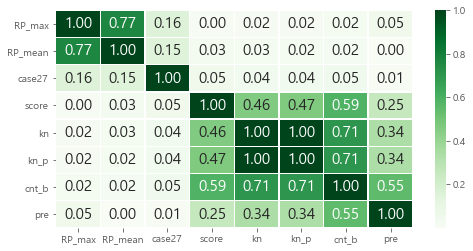

In [65]:
# 파라미터 & 타겟밸류 간 결정계수(=상관계수^2)
plt.figure(figsize=(8, 4))
sns.heatmap(  df_2[["RP_max","RP_mean","case27","score","kn","kn_p","cnt_b","pre",]].corr()**2, cmap="Greens", linewidths=.5, annot=True, annot_kws={'size':15}, fmt=".2f", )
plt.show()

In [66]:
infox(df_2[["case27","RP_mean","RP_max","cnt_p","pre","cnt_b"]])

◆◆◆ (115, 6): Total shape ◆◆◆
---(115, 6): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO   Column  null  null(%)    dtype  n_uniq  |     Mean      Std  |max-min|  │    min       Q1   median       Q3        max  
 0   case27     0      0.0  float64      44  |    2.017    3.249       18.2  │      0        0      0.9     2.65       18.2  
 1  RP_mean     0      0.0  float64       6  |    1.046   0.1196          1  │      1        1        1      1.1          2  
 2   RP_max     0      0.0  float64      12  |    1.252   0.2629          2  │      1      1.1      1.2      1.3          3  
 3    cnt_p     0      0.0    int64      93  |    4,738    9,762     45,958  │      1       17      152    3,083     45,959  
 4      pre     0      0.0    int64     115  |  254,975  163,381  1,302,417  │  5,200  159,811  243,948  327,971  1,307,617  
 5    cnt_b     0      0.0  float64      86  |    11.85    6.603       28.4  │      1     7.75     10.6     15.7       29.4  
------------

### 3_연령대 & 성별만

In [67]:
cols = ['cnt_p','PRE_1', 'PRE_2', 'PRE_3', 'PRE_4','CNT_1', 'CNT_2', 'CNT_3', 'CNT_4',
        'cnt_b', 'pre', 'post', 'c_back', 'dscnt', 'total',
        'RP_max', 'RP_mean','case27', 'kn', 'kn_p', 'score',
        'AGE', 'man', 'push', 'frgn', ]
df_3 = df9[cols].groupby(["AGE","man"]).sum()

print(df_3.shape)
display(df_3)

### 각 유저가 가지는 독립변수 나이대, 성별, 알람, 외국인 여부에 따라 
###                           19  x  2  x 2    x 2 = 152(최대) 그룹으로 나누고 ---> 매출, 횟수 등을 감안해서 그룹으로 묶기

(37, 23)


cnt_p  PRE_1  PRE_2  PRE_3  PRE_4  CNT_1  CNT_2  CNT_3  CNT_4  \
AGE man                                                                  
15  0     3092      0     35    797   2260      0     92   1020   1980   
    1     1070      0     16    221    833      0     14    213    843   
20  0    32357      0   1341  11409  19607      0   2023  11399  18935   
    1    11203      0    328   3905   6970      0    249   2621   8333   
25  0    60743      5   3810  21643  35285      6   4853  21149  34735   
    1    29640      2   1311   9974  18353      0   1039   8258  20343   
30  0    67236      4   5189  23445  38598      7   6121  24211  36897   
    1    34658      3   1890  10756  22009      1   1325  10559  22773   
35  0    76666      2   6603  26965  43096      7   8070  28154  40435   
    1    42326     12   2743  13026  26545      2   2125  13945  26254   
40  0    55974      3   6372  19907  29692     11   7729  19854  28380   
    1    36681      9   2856  12078  21738      3   2628  12808  21242   
45  0    26842      0   3678   9599  13565      8   4400   9340  13094   
    1    21369      7   1848   7217  12297      2   1915   7467  11985   
50  0    13290      0   2071   4753   6466      0   2489   4529   6272   
    1     9830      3    984   3380   5463      1   1103   3488   5238   
55  0     5354      1    844   1809   2700      3    973   1750   2628   
    1     3689      0    418   1262   2009      2    500   1277   1910   
60  0     3016      1    457    938   1620      0    525    931   1560   
    1     2157      1    229    705   1222      0    297    730   1130   
65  0     1221      0    147    335    739      1    154    372    694   
    1     1029      0    109    361    559      0    148    368    513   
70  0      490      1     56    130    303      0     51    155    284   
    1      378      0     39    108    231      0     45    118    215   
75  0      239      0     24     70    145      0     24     81    134   
    1      186      0     24     53    109      0     26     62     98   
80  0      103      0     12     36     55      0     12     47     44   
    1       74      0      9     26     39      0      9     31     34   
85  0       59      0      8     21     30      0     13     24     22   
    1       23      0      4      5     14      0      3      7     13   
90  0       13      0      3      3      7      0      2      6      5   
    1        8      0      1      3      4      0      1      3      4   
95  0        1      0      0      0      1      0      0      0      1   
    1        1      0      0      0      1      0      0      0      1   
100 0        1      0      0      0      1      0      0      1      0   
120 0     2785      0     51    227   2507      0     24    212   2549   
    1     1117      0     29    106    982      0      6     84   1027   

          cnt_b          pre         post     c_back       dscnt       total  \
AGE man                                                                        
15  0     18980    263859640    241915325    1724338    20219977    21944315   
    1      4241     88088806     81231098     419240     6438468     6857708   
20  0    267598   4794375259   4435178459   32781401   326415399   359196800   
    1     52622   1509224096   1414425479    9701605    85097012    94798617   
25  0    568626  11114394437  10288952421   71291023   754150993   825442016   
    1    174442   4669206733   4353587816   29151618   286467299   315618917   
30  0    703103  13766315109  12720307446   84300332   961707331  1046007663   
    1    223980   5933666189   5496480159   31969809   405216221   437186030   
35  0    881275  16614613428  15307475718  102382112  1204755598  1307137710   
    1    317444   8191679252   7578157906   39451203   574070143   613521346   
40  0    778916  14606380670  13472974181   90377606  1043028883  1133406489   
    1    331555   7809260096   7212116886   40981315   556161895   597143210   
45

In [68]:
df_33 = df_3.reset_index()

df_33m = df_33.loc[df_33.man==1,["AGE","pre"]]
df_33m.loc[34] = [100,0]
df_33m = df_33m.sort_values("AGE")
df_33m = df_33m.set_index("AGE")

df_33f = df_33.loc[df_33.man==0,["AGE","pre"]]
df_33f = df_33f.sort_values("AGE")
df_33f = df_33f.set_index("AGE")

print(df_33m.shape, df_33f.shape)

(19, 1) (19, 1)


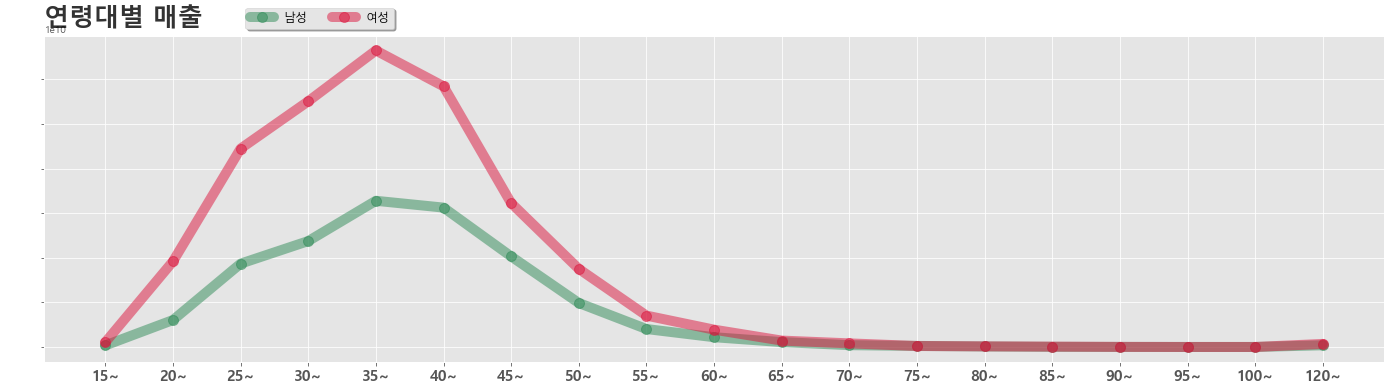

In [69]:
x, x_name, m, f = range(19), df_33m.index, df_33m.pre, df_33f.pre

plt.figure(figsize=((24,6)))
plt.plot( x, m, color="seagreen", label="남성", alpha=0.5, ls="-", linewidth=10, marker='o', ms=10, mfc="seagreen", solid_capstyle='round', )
plt.plot( x, f, color="Crimson", label="여성", alpha=0.5, ls="-", linewidth=10, marker='o', ms=10, mfc="Crimson", solid_capstyle='round', )
plt.title("연령대별 매출", weight=1000, color="k", size=25, alpha=0.8, pad=10, loc="left", )
plt.xticks( x, [f"{i}~" for i in x_name], fontsize=15, rotation=0, weight=1000, )
plt.yticks( color="w", fontsize=15, rotation=0, weight=1000, )
plt.legend( loc=(0.15,1.02), fontsize=12, ncol=2, frameon=True, shadow=True, )
plt.show()

In [70]:
여기부터 수정하면 된다 ↓↓↓

SyntaxError: invalid syntax (<ipython-input-70-f3dd1325b5d3>, line 1)

,,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score,push,frgn
AGE,man,,,,,,,,,,,,,,,,,,,,,,,
15,0,3092,0,35,797,2260,0,92,1020,1980,18980,263859640,241915325,1724338,20219977,21944315,3255,3133.31,4,76285.981767,77087.038569,106871.9,2190,0


In [ ]:
### 단위/유효숫자 처리
a = [0, 100,100,100,100,100,100,100,100, 1, 0,0,0,0,0, 1,1, 100, 1,1,1, 100,100,]  # 곱해줄 상수 ---> 백분위 피쳐만 x100
w = [0,   1,  1,  1,  1,  1,  1,  1,  1, 1, 0,0,0,0,0, 1,1,   1, 1,1,1,   1,  1,]  # 유효숫자 갯수
for i in range(1,23):
    if 10<=i<=14:
        df_3.iloc[:,i] = df_3.iloc[:,i]//df_3.iloc[:,0]
    else: df_3.iloc[:,i] = round(a[i]*df_3.iloc[:,i]/df_3.iloc[:,0],w[i])
infox(df_3[["cnt_p","pre","case27"]])

◆◆◆ (37, 3): Total shape ◆◆◆
---(37, 3): Numeric Data: only Real Number ↓↓↓ ---------------------------
NO  Column  null  null(%)    dtype  n_uniq  |     Mean      Std  |max-min|  │    min       Q1   median       Q3      max  
 0   cnt_p     0      0.0    int64      35  |   14,727   21,506     76,665  │      1      186    2,785   26,842   76,666  
 1     pre     0      0.0    int64      37  |  229,286  108,319    406,601  │  5,200  157,530  250,771  318,182  411,801  
 2  case27     0      0.0  float64      27  |    2.346    2.112        8.7  │      0      0.9      1.7      3.6      8.7  
------------------------------------------------------------------------------ 



In [ ]:
df_3.sort_values(by=["pre","cnt_b"],ascending=[False,False])

,,cnt_p,PRE_1,PRE_2,PRE_3,PRE_4,CNT_1,CNT_2,CNT_3,CNT_4,cnt_b,pre,post,c_back,dscnt,total,RP_max,RP_mean,case27,kn,kn_p,score,push,frgn
AGE,man,,,,,,,,,,,,,,,,,,,,,,,
70,0,490,0.2,11.4,26.5,61.8,0.0,10.4,31.6,58.0,11.3,411801,387681,1236,22883,24120,1.4,1.1,6.5,28.0,28.4,37.2,56.5,0.2
90,0,13,0.0,23.1,23.1,53.8,0.0,15.4,46.2,38.5,18.5,401780,366782,1352,33646,34998,1.6,1.1,7.7,34.4,34.9,38.5,46.2,0.0
80,1,74,0.0,12.2,35.1,52.7,0.0,12.2,41.9,45.9,11.7,389866,366823,1006,22035,23042,1.5,1.2,5.4,29.4,29.9,34.3,66.2,0.0
85,1,23,0.0,17.4,21.7,60.9,0.0,13.0,30.4,56.5,13.3,374950,348426,3527,22996,26524,1.9,1.3,8.7,31.6,32.0,32.4,52.2,0.0
80,0,103,0.0,11.7,35.0,53.4,0.0,11.7,45.6,42.7,14.3,336301,310449,1135,24715,25851,1.6,1.2,2.9,32.6,33.1,40.0,67.0,0.0
85,0,59,0.0,13.6,35.6,50.8,0.0,22.0,40.7,37.3,18.2,334334,308729,1004,24600,25605,1.4,1.1,1.7,35.7,36.1,40.9,69.5,0.0
50,0,13290,0.0,15.6,35.8,48.7,0.0,18.7,34.1,47.2,18.1,329269,304652,2123,22493,24616,1.2,1.0,0.9,35.9,36.2,41.8,73.1,0.5
55,0,5354,0.0,15.8,33.8,50.4,0.1,18.2,32.7,49.1,17.9,328600,304531,2067,22002,24069,1.2,1.0,1.3,34.7,35.1,41.5,73.2,0.6
60,0,3016,0.0,15.2,31.1,53.7,0.0,17.4,30.9,51.7,17.0,321847,298252,1977,21617,23594,1.3,1.1,1.8,33.3,33.7,39.6,68.1,0.4


# 부록_매출,횟수

In [76]:
N,n = len(df3), len(df3)//100  ## 전체 인원수, 1% 인원수
print(N,n)
pre_sum, cnt_sum = sum(df3.pre), sum(df3.cnt_b)  ## 전체 매출, 전체 구매횟수
print(f"{pre_sum:,}     {cnt_sum}")

data = df3[["pre","cnt_b","cnt_p"]].sort_values(by="pre",ascending=False)
data = data.reset_index(drop=True)
data

544921 5449
115,036,891,079     5623810


,pre,cnt_b,cnt_p
0,115005350,175,1
1,110444100,133,1
2,76952000,83,1
3,66233030,87,1
4,39306136,86,1
...,...,...,...
544916,500,1,1
544917,500,1,1
544918,500,1,1
544919,500,1,1


In [77]:
### 개인별 매출액 내림차순 한줄세우기 (1% 씩)
dic1 = [[i,round(100*sum(data.iloc[n*(i-1):n*i,0])/pre_sum,2),round(100*sum(data.iloc[:n*i,0])/pre_sum,2)] for i in range(1,101)]
df_rate = pd.DataFrame( dic1, columns=["상위","구간_pre(%)","누적_pre(%)"] )
sero(df_rate,20)

,상위,구간_pre(%),누적_pre(%)
0,1,15.87,15.87
1,2,7.95,23.82
2,3,6.11,29.93
3,4,5.06,35.00
4,5,4.45,39.45
5,6,3.93,43.38
6,7,3.48,46.87
7,8,3.14,50.00
8,9,2.85,52.85
9,10,2.61,55.46


,상위,구간_pre(%),누적_pre(%)
20,21,1.25,74.58
21,22,1.18,75.76
22,23,1.12,76.88
23,24,1.06,77.94
24,25,1.00,78.94
25,26,0.95,79.90
26,27,0.91,80.80
27,28,0.86,81.67
28,29,0.82,82.49
29,30,0.78,83.27


,상위,구간_pre(%),누적_pre(%)
40,41,0.48,89.91
41,42,0.46,90.37
42,43,0.44,90.81
43,44,0.42,91.23
44,45,0.40,91.64
45,46,0.39,92.03
46,47,0.37,92.40
47,48,0.36,92.75
48,49,0.34,93.09
49,50,0.33,93.42


,상위,구간_pre(%),누적_pre(%)
60,61,0.21,96.23
61,62,0.20,96.43
62,63,0.19,96.62
63,64,0.18,96.80
64,65,0.18,96.98
65,66,0.17,97.15
66,67,0.16,97.31
67,68,0.15,97.46
68,69,0.15,97.61
69,70,0.14,97.75


,상위,구간_pre(%),누적_pre(%)
80,81,0.09,98.98
81,82,0.08,99.06
82,83,0.08,99.14
83,84,0.08,99.22
84,85,0.07,99.29
85,86,0.07,99.36
86,87,0.07,99.43
87,88,0.06,99.49
88,89,0.06,99.55
89,90,0.06,99.61


,상위,구간_pre(%),누적_pre(%)


,상위,구간_pre(%),누적_pre(%)


In [78]:
data = df3[["pre","cnt_b","cnt_p"]].sort_values(by="cnt_b",ascending=False)
data = data.reset_index(drop=True)
data

,pre,cnt_b,cnt_p
0,27186523,2705,1
1,35043786,2630,1
2,27831148,1684,1
3,22056535,1363,1
4,15070935,1229,1
...,...,...,...
544916,7000,1,1
544917,9800,1,1
544918,19900,1,1
544919,8910,1,1


In [79]:
### 개인별 구매횟수 내림차순 한줄세우기 (1% 씩)
dic2 = [[i,round(100*sum(data.iloc[n*(i-1):n*i,1])/cnt_sum,2),round(100*sum(data.iloc[:n*i,1])/cnt_sum,2)] for i in range(1,101)]
df_rate2 = pd.DataFrame( dic2, columns=["상위","구간_cnt(%)","누적_cnt(%)"] )
sero(df_rate2,20)

,상위,구간_cnt(%),누적_cnt(%)
0,1,13.76,13.76
1,2,8.02,21.78
2,3,6.28,28.06
3,4,5.24,33.30
4,5,4.53,37.82
5,6,3.98,41.80
6,7,3.57,45.38
7,8,3.23,48.60
8,9,2.93,51.53
9,10,2.69,54.22


,상위,구간_cnt(%),누적_cnt(%)
20,21,1.26,73.77
21,22,1.19,74.96
22,23,1.14,76.10
23,24,1.07,77.17
24,25,1.01,78.18
25,26,0.97,79.15
26,27,0.91,80.06
27,28,0.87,80.93
28,29,0.83,81.76
29,30,0.78,82.54


,상위,구간_cnt(%),누적_cnt(%)
40,41,0.48,89.14
41,42,0.48,89.62
42,43,0.41,90.03
43,44,0.39,90.42
44,45,0.39,90.81
45,46,0.39,91.20
46,47,0.39,91.58
47,48,0.39,91.97
48,49,0.31,92.28
49,50,0.29,92.57


,상위,구간_cnt(%),누적_cnt(%)
60,61,0.19,95.34
61,62,0.19,95.54
62,63,0.19,95.73
63,64,0.19,95.93
64,65,0.19,96.12
65,66,0.19,96.31
66,67,0.19,96.51
67,68,0.19,96.70
68,69,0.19,96.89
69,70,0.19,97.09


,상위,구간_cnt(%),누적_cnt(%)
80,81,0.1,98.16
81,82,0.1,98.26
82,83,0.1,98.35
83,84,0.1,98.45
84,85,0.1,98.55
85,86,0.1,98.64
86,87,0.1,98.74
87,88,0.1,98.84
88,89,0.1,98.93
89,90,0.1,99.03


,상위,구간_cnt(%),누적_cnt(%)


,상위,구간_cnt(%),누적_cnt(%)


In [ ]:
파일참조: 1008

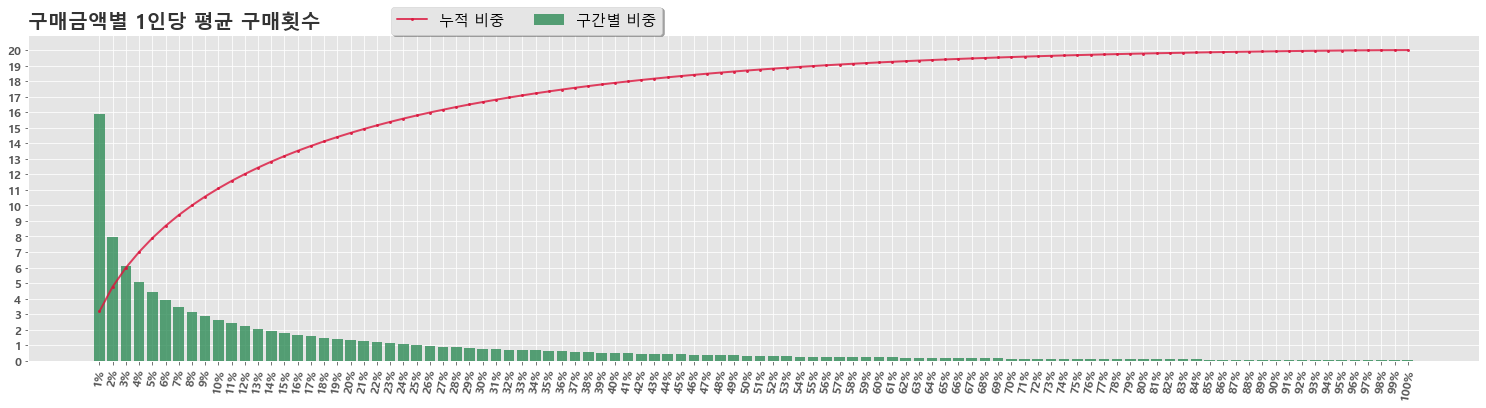

In [ ]:
x,y1,y2 = range(1,101), df_rate.구간, df_rate.누적
plt.figure(figsize=((26,6)))
plt.bar(  x, y1,   label="구간별 비중", alpha=0.8, color ="seagreen", )
plt.plot( x, y2/5, label="누적 비중",   alpha=0.8, lw=2, ls="-", color ="crimson", marker='o', ms=2, mfc="crimson", solid_capstyle='round' )
plt.xticks(x, [f"{i}%" for i in df_rate.index], size=12, weight=1000, rotation=80 )
plt.yticks(range(21), size=12, weight=1000, )
plt.title("구매금액별 "+cols_tag[i], weight=1000, color="k", size=20, alpha=0.8, loc="left", )
plt.legend(loc=(0.25,1), ncol=2, fontsize=15, frameon=True, shadow=True)
plt.show()